In [ ]:
"""
=============================================================================
NEURIPS 2025 EEG FOUNDATION CHALLENGE - CHALLENGE 2
=============================================================================

Challenge 2: Psychopathology Factor Prediction (70% of Final Score)

This script implements a complete training pipeline for predicting 4 psychopathology
factors from EEG data:
- p_factor: General psychopathology dimension
- internalizing: Anxiety, depression, withdrawal symptoms
- externalizing: ADHD, conduct problems, aggression
- attention: Attention deficit and hyperactivity measures

Key Features:
- Subject-level cross-validation (prevents data leakage)
- 4-vector output regression
- Averaged normalized RMSE evaluation
- Interactive training with model selection
- Modular architecture (ViT + CNN options)

Based on Challenge 1 structure but adapted for multi-factor prediction.

Author: Neurips EEG Challenge Team
Date: January 2025
"""

'\n=============================================================================\nNEURIPS 2025 EEG FOUNDATION CHALLENGE - CHALLENGE 2\n=============================================================================\n\nChallenge 2: Psychopathology Factor Prediction (70% of Final Score)\n\nThis script implements a complete training pipeline for predicting 4 psychopathology \nfactors from EEG data:\n- p_factor: General psychopathology dimension  \n- internalizing: Anxiety, depression, withdrawal symptoms\n- externalizing: ADHD, conduct problems, aggression  \n- attention: Attention deficit and hyperactivity measures\n\nKey Features:\n- Subject-level cross-validation (prevents data leakage)\n- 4-vector output regression \n- Averaged normalized RMSE evaluation\n- Interactive training with model selection\n- Modular architecture (ViT + CNN options)\n\nBased on Challenge 1 structure but adapted for multi-factor prediction.\n\nAuthor: Neurips EEG Challenge Team\nDate: January 2025\n'

# SECTION 1: GOOGLE COLAB SETUP AND INSTALLATIONS

In [ ]:
# Install required libraries not available in Google Colab by default
import subprocess
import sys

def install_requirements():
    """Install required packages for Challenge 2"""

    print("🔧 Installing required packages for Challenge 2...")

    # List of required packages not in Colab by default
    packages = [
        'eegdash',           # EEG Challenge dataset loader
        'braindecode',       # EEG preprocessing utilities
        'mne',              # MNE-Python for EEG processing
    ]

    for package in packages:
        try:
            print(f"📦 Installing {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
            print(f"✅ {package} installed successfully")
        except subprocess.CalledProcessError as e:
            print(f"❌ Failed to install {package}: {e}")
            print(f"   Try running: !pip install {package}")

    print("🎉 Package installation complete!")

# Run installation (comment out after first run if needed)
install_requirements()

🔧 Installing required packages for Challenge 2...
📦 Installing eegdash...
✅ eegdash installed successfully
📦 Installing braindecode...
✅ braindecode installed successfully
📦 Installing mne...
✅ mne installed successfully
🎉 Package installation complete!


# SECTION 2: CONFIGURATION AND SETUP

In [ ]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Set environment variables for optimal performance
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

# SECTION 3: IMPORT LIBRARIES

In [ ]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import pickle
from datetime import datetime
import gc
from typing import Dict, List, Tuple, Optional, Union
from dataclasses import dataclass

# Competition and EEG libraries
from eegdash.dataset import EEGChallengeDataset
from braindecode.preprocessing import preprocess, Preprocessor
import mne
from mne import pick_types

# Machine learning libraries
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as stats

# Cross-validation (subject-level splits)
from sklearn.model_selection import GroupKFold

# Deep learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau, ExponentialLR
from tqdm import tqdm

# Visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# SECTION 4: DATA LOADING AND VALIDATION FUNCTIONS

In [ ]:

def extract_challenge2_pfactor(participants_df, subject_id):
    """
    Extract p-factor for Challenge 2 from participants.tsv

    ⚠️ UPDATED: Challenge simplified to predict ONLY p-factor

    Args:
        participants_df: DataFrame with participant metadata
        subject_id: Subject identifier (e.g., 'sub-NDARAC904DMU')

    Returns:
        float: P-factor value or None if missing data
    """
    try:
        # Find subject row
        subject_row = participants_df[participants_df.participant_id == subject_id]

        if len(subject_row) == 0:
            print(f"  ❌ Subject {subject_id} not found in participants.tsv")
            return None

        subject_data = subject_row.iloc[0]

        # Extract ONLY p-factor (challenge simplified)
        p_factor = subject_data['p_factor']

        # Check for missing data
        if pd.isna(p_factor):
            print(f"  ⚠️ Subject {subject_id} missing p-factor")
            return None

        print(f"  ✅ Extracted p-factor: {p_factor:.3f}")

        return float(p_factor)

    except Exception as e:
        print(f"  ❌ Error extracting p-factor for {subject_id}: {e}")
        return None

def load_challenge2_data(task="all_tasks", release="R5", dataset_size="full"):
    """
    Load EEG data for Challenge 2 psychopathology prediction

    Challenge 2 can use any task since we're predicting subject-level traits,
    not task-specific responses. We'll use all available tasks for maximum data.

    Args:
        task: Task name or "all_tasks" for multi-task data
        release: Data release to use
        dataset_size: Dataset size - "full", "medium" (~75%), or "mini" (small subset)

    Returns:
        EEGChallengeDataset: Loaded dataset with EEG and metadata
    """
    print(f"\nLOADING CHALLENGE 2 DATA")
    print("=" * 50)

    try:
        # Load dataset - for Challenge 2, we can use multiple tasks
        # For Challenge 2, we can use any task since we're predicting subject-level traits
        # Let's use contrastChangeDetection as it's well-validated for Challenge 1
        if task == "all_tasks":
            print("📊 Loading EEG data for Challenge 2...")
            print("   Using contrastChangeDetection task (subject traits are task-independent)")
            task = "contrastChangeDetection"

        # Load dataset with correct API (matching Challenge 1)
        dataset = EEGChallengeDataset(
            task=task,
            release=release,
            cache_dir="./eeg_cache"
        )

        # Handle different dataset sizes
        if dataset_size == "mini":
            print("🔬 Using mini dataset for testing...")
            # Keep only first few subjects for quick testing
            dataset.datasets = dataset.datasets[:10]
        elif dataset_size == "medium":
            print("📊 Using medium dataset (~75% of full data)...")
            # Keep roughly 75% of the dataset
            import random
            total_recordings = len(dataset.datasets)
            medium_size = int(total_recordings * 0.75)
            # Use random sampling to get a representative subset
            random.seed(42)  # For reproducibility
            indices = random.sample(range(total_recordings), medium_size)
            indices.sort()  # Keep indices sorted for consistent ordering
            dataset.datasets = [dataset.datasets[i] for i in indices]
            print(f"   Selected {len(dataset.datasets)} recordings from {total_recordings} total ({len(dataset.datasets)/total_recordings*100:.1f}%)")
        else:  # dataset_size == "full"
            print("🎯 Using full dataset...")

        print(f"✅ Dataset loaded: {len(dataset)} recordings")

        # Get basic specs from first recording
        first_raw = dataset.datasets[0].raw
        n_channels = len(first_raw.ch_names)
        sfreq = first_raw.info['sfreq']
        duration = first_raw.times[-1]

        print(f"📊 Data specs:")
        print(f"   Channels: {n_channels}")
        print(f"   Original sampling rate: {sfreq} Hz")
        print(f"   Duration: {duration:.1f} seconds")

        # Load participants.tsv for psychopathology factors
        # Try multiple possible locations for participants.tsv
        possible_paths = [
            Path("Dataset/Release_1/participants.tsv"),  # Original hardcoded path
            Path("./eeg_cache") / "participants.tsv",    # Cache directory
            Path("./eeg_cache") / release / "participants.tsv",  # Cache with release subdirectory
            Path("participants.tsv"),  # Current directory
        ]

        participants_df = None
        for participants_path in possible_paths:
            if participants_path.exists():
                print(f"📊 Found participants.tsv at: {participants_path}")
                participants_df = pd.read_csv(participants_path, sep='\t')
                print(f"📊 Loaded participant metadata: {len(participants_df)} subjects")
                break

        if participants_df is None:
            # Try to find it in the dataset object if available
            print("🔍 Searching for participants.tsv in dataset cache...")
            import glob
            cache_files = glob.glob("./eeg_cache/**/participants.tsv", recursive=True)
            if cache_files:
                participants_path = cache_files[0]
                print(f"📊 Found participants.tsv at: {participants_path}")
                participants_df = pd.read_csv(participants_path, sep='\t')
                print(f"📊 Loaded participant metadata: {len(participants_df)} subjects")
            else:
                print("❌ Could not find participants.tsv in any expected location")
                print("📁 Available files in cache:")
                import os
                if os.path.exists("./eeg_cache"):
                    for root, dirs, files in os.walk("./eeg_cache"):
                        for file in files[:10]:  # Show first 10 files
                            print(f"   {os.path.join(root, file)}")
                raise FileNotFoundError("participants.tsv not found in any expected location")

        # Data validation for Challenge 2
        print(f"\n🔍 CHALLENGE 2 DATA VALIDATION:")
        print(f"   Task: {task}")
        print(f"   Release: {release}")
        print(f"   Dataset size: {dataset_size}")

        # Check psychopathology factor availability
        # Check p-factor availability (challenge simplified to p-factor only)
        if 'p_factor' not in participants_df.columns:
            print(f"   ❌ Missing p_factor column")
            return None

        print(f"   ✅ P-factor available (challenge simplified to p-factor only)")

        # Check for missing data in p-factor
        missing_count = participants_df['p_factor'].isna().sum()
        total_count = len(participants_df)
        print(f"   📊 p_factor: {total_count - missing_count}/{total_count} subjects have data "
              f"({missing_count} missing)")

        # Store participants_df in dataset for later use
        dataset.participants_df = participants_df

        return dataset

    except Exception as e:
        print(f"❌ Error loading Challenge 2 data: {e}")
        return None

def create_challenge2_windows(dataset, window_length=2.0, target_sfreq=100, overlap=0.0):
    """
    Create windows for Challenge 2 psychopathology prediction

    Unlike Challenge 1 (event-aligned), Challenge 2 uses sliding windows since
    we're predicting subject-level traits, not event-specific responses.

    Args:
        dataset: EEGChallengeDataset with participants_df attached
        window_length: Window length in seconds
        target_sfreq: Target sampling frequency
        overlap: Window overlap (0.0 = no overlap, 0.5 = 50% overlap)

    Returns:
        X: EEG windows (n_samples, n_timepoints, n_channels)
        y: Psychopathology factors (n_samples, 4)
        metadata: Subject and window information
    """
    print("\nCREATING CHALLENGE 2 WINDOWS")
    print("=" * 40)

    all_windows = []
    all_labels = []
    all_metadata = []
    window_samples = int(window_length * target_sfreq)
    step_samples = int(window_samples * (1 - overlap))

    subjects_with_data = 0
    subjects_without_factors = 0

    for i, ds in enumerate(dataset.datasets):
        raw = ds.raw

        # Extract subject ID from the dataset object or raw info
        if hasattr(ds, 'subject_id'):
            subject_id = ds.subject_id
        elif hasattr(ds, 'subject'):
            subject_id = ds.subject
        elif hasattr(raw, 'info') and 'subject_info' in raw.info:
            subject_id = raw.info['subject_info'].get('his_id', f'subject_{i+1}')
        else:
            # Try to extract from filename or description
            if hasattr(raw, 'info') and raw.info.get('filename'):
                filename = str(raw.info['filename'])
                # Extract subject ID from filename like "sub-NDARAH793FBF_task-..."
                import re
                match = re.search(r'sub-([A-Z0-9]+)', filename)
                subject_id = f"sub-{match.group(1)}" if match else f"subject_{i+1}"
            else:
                # Debug: show available attributes
                if i == 0:  # Only show for first recording to avoid spam
                    print(f"🔍 Debug: Dataset object attributes: {[attr for attr in dir(ds) if not attr.startswith('_')]}")
                    if hasattr(raw, 'info'):
                        print(f"🔍 Debug: Raw info keys: {list(raw.info.keys())}")
                subject_id = f"subject_{i+1}"

        print(f"\nProcessing recording {i+1}: {subject_id}")
        eeg_data = raw.get_data()  # Shape: (n_channels, n_samples)
        sfreq = raw.info['sfreq']
        duration = raw.times[-1]

        print(f"  Duration: {duration:.1f}s, Sampling rate: {sfreq}Hz")

        # Extract p-factor for this subject (challenge simplified)
        p_factor = extract_challenge2_pfactor(
            dataset.participants_df, subject_id
        )

        if p_factor is None:
            subjects_without_factors += 1
            print(f"  ⚠️ Skipping {subject_id} - no valid p-factor")
            continue

        subjects_with_data += 1

        # Create sliding windows across the entire recording
        n_samples = eeg_data.shape[1]
        n_windows = 0

        for start_idx in range(0, n_samples - window_samples + 1, step_samples):
            end_idx = start_idx + window_samples

            # Extract window
            window_data = eeg_data[:, start_idx:end_idx]  # (n_channels, window_samples)
            window_data = window_data.T  # (window_samples, n_channels) - match Challenge 1 format

            # Store window
            all_windows.append(window_data)

            # Store p-factor (same for all windows from this subject)
            all_labels.append(p_factor)

            # Store metadata
            metadata = {
                'subject_id': subject_id,
                'window_idx': n_windows,
                'start_time': start_idx / sfreq,
                'end_time': end_idx / sfreq,
                'task': ds.task if hasattr(ds, 'task') else 'unknown',
                'p_factor': p_factor
            }
            all_metadata.append(metadata)
            n_windows += 1

        print(f"  ✅ Created {n_windows} windows from {subject_id}")

    if len(all_windows) == 0:
        print("❌ No valid windows created - check p-factor availability")
        return None, None, None

    # Convert to arrays
    X = np.array(all_windows)  # (n_samples, n_timepoints, n_channels)
    y = np.array(all_labels)   # (n_samples,) - single p-factor values

    print(f"\n✅ Created Challenge 2 dataset:")
    print(f"   Windows: {X.shape} (samples, time, channels)")
    print(f"   Labels: {y.shape} (samples, p-factor)")
    print(f"   Subjects with data: {subjects_with_data}")
    print(f"   Subjects without p-factor: {subjects_without_factors}")

    # Print p-factor statistics
    print(f"   P-factor statistics:")
    mean_val = np.mean(y)
    std_val = np.std(y)
    min_val = np.min(y)
    max_val = np.max(y)
    print(f"     p_factor: mean={mean_val:.3f}, std={std_val:.3f}, "
          f"range=[{min_val:.3f}, {max_val:.3f}]")

    return X, y, all_metadata

# SECTION 5: PREPROCESSING PIPELINE

In [ ]:
def create_challenge2_preprocessing_pipeline(sfreq, target_sfreq=100):
    """
    Create preprocessing pipeline for Challenge 2
    Same as Challenge 1 since we use the same EEG processing
    """
    print(f"\nCREATING PREPROCESSING PIPELINE")
    print(f"Original sampling rate: {sfreq} Hz")
    print(f"Target sampling rate: {target_sfreq} Hz (Competition Standard)")
    print("-" * 40)

    preprocessors = []

    # Determine filtering and resampling strategy
    nyquist = sfreq / 2
    target_nyquist = target_sfreq / 2

    if sfreq == target_sfreq:
        print(f"📊 Already at target sampling rate - simplified preprocessing")

        # High-pass and low-pass filtering
        l_freq = 0.5  # High-pass at 0.5 Hz
        h_freq = min(48.0, target_nyquist - 2)  # Low-pass, leave 2Hz margin

        preprocessors.append(Preprocessor('filter', l_freq=l_freq, h_freq=h_freq, verbose=False))
        print(f"   🔍 Bandpass filter: {l_freq}-{h_freq} Hz")

        # Check if 60Hz notch filtering is possible
        if target_nyquist > 62:
            preprocessors.append(Preprocessor('notch_filter', freqs=60, verbose=False))
            print(f"   ⚡ 60Hz notch filter: Applied")
        else:
            print(f"   ⚠️  60Hz notch filter NOT applicable (above Nyquist)")
    else:
        print(f"📊 Resampling required: {sfreq}Hz → {target_sfreq}Hz")

        # Filter before resampling (anti-aliasing)
        l_freq = 0.5
        h_freq = min(48.0, target_nyquist - 2)

        preprocessors.append(Preprocessor('filter', l_freq=l_freq, h_freq=h_freq, verbose=False))
        print(f"   🔍 Pre-resampling filter: {l_freq}-{h_freq} Hz")

        # Resample
        preprocessors.append(Preprocessor('resample', sfreq=target_sfreq, verbose=False))
        print(f"   📐 Resample: {sfreq}Hz → {target_sfreq}Hz")

        # Post-resampling 60Hz notch if applicable
        if target_sfreq > 120:
            preprocessors.append(Preprocessor('notch_filter', freqs=60, verbose=False))
            print(f"   ⚡ 60Hz notch filter: Applied after resampling")

    # Common reference
    preprocessors.append(Preprocessor('set_eeg_reference', ref_channels='average', verbose=False))
    print(f"   🎯 Reference: Average reference")

    print(f"\nPipeline created:")
    for i, prep in enumerate(preprocessors, 1):
        # Handle different Preprocessor attribute names
        if hasattr(prep, 'fn_name'):
            fn_name = prep.fn_name
        elif hasattr(prep, 'fn'):
            fn_name = prep.fn if isinstance(prep.fn, str) else prep.fn.__name__
        else:
            fn_name = str(prep)

        if hasattr(prep, 'kwargs'):
            params = prep.kwargs
        else:
            params = "N/A"

        print(f"  {i}. {fn_name}: {params}")

    # Frequency analysis summary
    print(f"\n📊 Frequency Analysis:")
    print(f"   Original Nyquist frequency: {nyquist} Hz")
    print(f"   Target Nyquist frequency: {target_nyquist} Hz")
    if target_nyquist > 62:
        print(f"   60Hz line noise filtering: ✅ Applied")
    else:
        print(f"   60Hz line noise filtering: ❌ Skipped (above Nyquist limit)")

    return preprocessors

def apply_challenge2_preprocessing(dataset, preprocessors):
    """Apply preprocessing pipeline to Challenge 2 dataset"""
    print(f"\nAPPLYING PREPROCESSING...")

    try:
        preprocess(dataset, preprocessors, n_jobs=1)

        # Verify preprocessing results
        first_raw = dataset.datasets[0].raw
        final_sfreq = first_raw.info['sfreq']
        final_shape = first_raw.get_data().shape

        print(f"✅ Preprocessing complete:")
        print(f"   Final sampling rate: {final_sfreq} Hz")
        print(f"   Final shape: {final_shape}")

        return dataset

    except Exception as e:
        print(f"❌ Preprocessing failed: {e}")
        return None

# SECTION 6: MODEL ARCHITECTURES

In [ ]:
class Challenge2Dataset(Dataset):
    """PyTorch Dataset for Challenge 2 psychopathology prediction"""

    def __init__(self, X, y, metadata, transform=None):
        """
        Args:
            X: EEG windows (n_samples, n_timepoints, n_channels)
            y: Psychopathology factors (n_samples, 4)
            metadata: List of metadata dictionaries
        """
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)  # 4 factors per sample
        self.metadata = metadata
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]  # (n_timepoints, n_channels)
        y = self.y[idx]  # scalar - single p-factor value

        if self.transform:
            x = self.transform(x)

        return x, y

class ModelRegistry:
    """Registry for different model architectures for Challenge 2"""

    def __init__(self):
        self.models = {}
        self._register_default_models()

    def _register_default_models(self):
        """Register default model architectures"""
        self.register('transformer_vit', EEGGPTChallenge2)
        self.register('raw_eeg_cnn', RawEEGCNNChallenge2)

    def register(self, name, model_class):
        """Register a new model architecture"""
        self.models[name] = model_class

    def get_model(self, name, **kwargs):
        """Get a model instance by name"""
        if name not in self.models:
            raise ValueError(f"Model {name} not registered. Available: {list(self.models.keys())}")
        return self.models[name](**kwargs)

    def list_models(self):
        """List available model architectures"""
        return list(self.models.keys())

# Challenge 2 ViT Model (adapted from Challenge 1)
class EEGGPTChallenge2(nn.Module):
    """
    Vision Transformer for Challenge 2 p-factor prediction
    ⚠️ UPDATED: Challenge simplified to predict ONLY p-factor
    """

    def __init__(self, embed_dim=256, num_heads=8, num_layers=6,
                 input_channels=129, input_time=200,
                 attention_dropout=0.15, ffn_dropout=0.25, head_dropout=0.4):
        super().__init__()

        self.embed_dim = embed_dim
        self.input_channels = input_channels
        self.input_time = input_time
        self.attention_dropout = attention_dropout
        self.ffn_dropout = ffn_dropout
        self.head_dropout = head_dropout

        # Patch embedding: Convert EEG to patches
        # For (200, 129) input, use patch_size (10, 13) -> (20, ~10) patches
        self.patch_size = (10, 13)  # (time_patch, channel_patch)
        self.num_patches_time = input_time // self.patch_size[0]  # 20
        self.num_patches_channels = input_channels // self.patch_size[1]  # ~10
        self.num_patches = self.num_patches_time * self.num_patches_channels

        patch_dim = self.patch_size[0] * self.patch_size[1]  # 130

        # Patch projection
        self.patch_projection = nn.Conv2d(1, embed_dim,
                                        kernel_size=self.patch_size,
                                        stride=self.patch_size)

        # Positional embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        # Transformer encoder with simple layer-specific dropout
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=attention_dropout,  # Attention dropout (same for all layers)
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Challenge 2: Regression head with graduated dropout for p-factor only
        # Simple dropout - same rate throughout regression head
        # NO dropout before final layer to avoid obscuring predictions
        self.regression_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Dropout(head_dropout),  # Single dropout rate
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(head_dropout),  # Same dropout rate
            nn.Linear(embed_dim // 2, embed_dim // 4),
            nn.GELU(),
            # NO dropout here - preserve prediction quality
            nn.Linear(embed_dim // 4, 1)  # Single output: p-factor only
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize model weights"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv2d):
                # Use He uniform initialization for conv layers (EEG2Mel insight)
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        """
        Forward pass

        Args:
            x: Input EEG (batch_size, time, channels) = (batch_size, 200, 129)

        Returns:
            predictions: Psychopathology factors (batch_size, 4)
        """
        batch_size = x.size(0)

        # Add channel dimension: (batch_size, 1, time, channels)
        x = x.unsqueeze(1)  # (batch_size, 1, 200, 129)

        # Patch embedding
        x = self.patch_projection(x)  # (batch_size, embed_dim, num_patches_time, num_patches_channels)
        x = x.flatten(2).transpose(1, 2)  # (batch_size, num_patches, embed_dim)

        # Add CLS token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)  # (batch_size, num_patches + 1, embed_dim)

        # Add positional embeddings
        x = x + self.pos_embedding

        # Transformer encoding
        x = self.transformer(x)  # (batch_size, num_patches + 1, embed_dim)

        # Use CLS token for final prediction
        cls_output = x[:, 0]  # (batch_size, embed_dim)

        # Regression head - output p-factor only
        predictions = self.regression_head(cls_output)  # (batch_size, 1)

        return predictions.squeeze(-1)  # (batch_size,) - scalar output

# Challenge 2 CNN Model (adapted from Challenge 1)
class ResidualBlockChallenge2(nn.Module):
    """Residual block for Challenge 2 CNN (same as Challenge 1)"""

    def __init__(self, in_channels, out_channels, kernel_size=(4, 4), stride=1, dropout=0.1):
        super().__init__()

        # Calculate padding for consistent dimensions
        if isinstance(kernel_size, tuple):
            kh, kw = kernel_size
        else:
            kh = kw = kernel_size

        # Use explicit padding calculation for all cases to ensure compatibility
        padding = (kh//2, kw//2)

        # Main convolution path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(dropout)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

        # Skip connection - ensure output dimensions match
        self.skip_conv = None
        if in_channels != out_channels or stride != 1:
            self.skip_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1), stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # Main path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout(out)  # Dropout after first conv

        out = self.conv2(out)
        out = self.bn2(out)

        # Skip connection with dimension matching
        if self.skip_conv is not None:
            skip = self.skip_conv(x)
            # Handle potential dimension mismatches with adaptive pooling
            if out.shape != skip.shape:
                skip = F.adaptive_avg_pool2d(skip, out.shape[2:])
        else:
            skip = x
            if out.shape != skip.shape:
                skip = F.adaptive_avg_pool2d(skip, out.shape[2:])

        # Add skip connection
        out = out + skip
        out = self.relu2(out)

        return out

class RawEEGCNNChallenge2(nn.Module):
    """
    2D CNN for Challenge 2 p-factor prediction
    ⚠️ UPDATED: Challenge simplified to predict ONLY p-factor
    """

    def __init__(self, input_channels=129, input_time=200, cnn_dropout=0.1, fc_dropout=0.15, embed_dim=256):
        super().__init__()

        self.input_channels = input_channels
        self.input_time = input_time

        # Initial convolution
        self.initial_conv = nn.Conv2d(1, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        self.initial_bn = nn.BatchNorm2d(32)
        self.initial_relu = nn.ReLU(inplace=True)
        self.initial_pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # Residual blocks with increasing channels
        self.encoder_blocks = nn.ModuleList([
            ResidualBlockChallenge2(32, 64, stride=2, dropout=cnn_dropout),   # Downsample
            ResidualBlockChallenge2(64, 128, stride=2, dropout=cnn_dropout),  # Downsample
            ResidualBlockChallenge2(128, 256, stride=1, dropout=cnn_dropout), # Same size
            ResidualBlockChallenge2(256, 256, stride=1, dropout=cnn_dropout)  # Same size
        ])

        # Final conv layer
        self.final_conv = nn.Conv2d(256, 512, kernel_size=(3, 3), padding=(1, 1))
        self.final_bn = nn.BatchNorm2d(512)
        self.final_relu = nn.ReLU(inplace=True)

        # Compression layer (MaxPool instead of complex compression)
        self.compression = nn.AdaptiveMaxPool2d((4, 4))  # Fixed output size

        # Calculate flattened size
        self.flattened_size = 512 * 4 * 4  # 8192

        # Challenge 2: Regression head for p-factor only
        self.regression_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(fc_dropout),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(fc_dropout),
            nn.Linear(256, 1)  # Single output: p_factor only
        )

        # Initialize weights with He uniform (EEG2Mel approach)
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights using He uniform for conv layers"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        """
        Forward pass

        Args:
            x: Input EEG (batch_size, time, channels) = (batch_size, 200, 129)

        Returns:
            predictions: Psychopathology factors (batch_size, 4)
        """
        # Add depth dimension for 2D conv: (batch, 1, time, channels)
        x = x.unsqueeze(1)  # (batch_size, 1, 200, 129)

        # Initial convolution
        x = self.initial_conv(x)
        x = self.initial_bn(x)
        x = self.initial_relu(x)
        x = self.initial_pool(x)

        # Encoder blocks with residual connections
        for block in self.encoder_blocks:
            x = block(x)

        # Final conv layer
        x = self.final_conv(x)
        x = self.final_bn(x)
        x = self.final_relu(x)

        # Compression
        x = self.compression(x)  # (batch_size, 512, 4, 4)

        # Regression head - output p-factor only
        predictions = self.regression_head(x)  # (batch_size, 1)

        return predictions.squeeze(-1)  # (batch_size,) - scalar output


# SECTION 7: CROSS-VALIDATION WITH SUBJECT-LEVEL SPLITS

In [ ]:
def create_subject_cv_dataloaders(X, y, metadata, cv_folds=5, batch_size=32, random_state=42):
    """
    Create subject-level cross-validation dataloaders for Challenge 2

    CRITICAL: Split by subjects, not samples, to prevent data leakage
    since we're predicting subject-level traits.

    Args:
        X: EEG windows (n_samples, n_timepoints, n_channels)
        y: Psychopathology factors (n_samples, 4)
        metadata: List of metadata dicts with 'subject_id'
        cv_folds: Number of CV folds
        batch_size: Batch size for DataLoaders
        random_state: Random seed

    Returns:
        list: List of (train_loader, val_loader, train_subset, val_subset) tuples for each fold
        full_dataset: Complete dataset
    """
    print(f"\n🔄 CREATING {cv_folds}-FOLD SUBJECT-LEVEL CROSS-VALIDATION")
    print("=" * 60)

    # Create full dataset
    full_dataset = Challenge2Dataset(X, y, metadata)
    n_samples = len(full_dataset)

    # Extract subject IDs for grouping
    subject_ids = np.array([meta['subject_id'] for meta in metadata])
    unique_subjects = np.unique(subject_ids)
    n_subjects = len(unique_subjects)

    print(f"📊 Dataset overview:")
    print(f"   Total samples: {n_samples}")
    print(f"   Unique subjects: {n_subjects}")
    print(f"   Samples per subject: {n_samples / n_subjects:.1f} (average)")

    # Use GroupKFold to split by subjects
    group_kfold = GroupKFold(n_splits=cv_folds)
    cv_dataloaders = []

    for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X, y, groups=subject_ids)):
        # Get subject IDs for this fold
        train_subjects = set(subject_ids[train_idx])
        val_subjects = set(subject_ids[val_idx])

        print(f"📁 Fold {fold + 1}:")
        print(f"   Train: {len(train_idx)} samples from {len(train_subjects)} subjects")
        print(f"   Val: {len(val_idx)} samples from {len(val_subjects)} subjects")

        # Verify no subject overlap
        overlap = train_subjects.intersection(val_subjects)
        if overlap:
            raise ValueError(f"Subject overlap detected in fold {fold + 1}: {overlap}")

        # Create subset datasets
        train_subset = Subset(full_dataset, train_idx)
        val_subset = Subset(full_dataset, val_idx)

        # Create data loaders
        train_loader = DataLoader(
            train_subset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=True
        )

        val_loader = DataLoader(
            val_subset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=True
        )

        cv_dataloaders.append((train_loader, val_loader, train_subset, val_subset))

    print(f"✅ Created {cv_folds} subject-level cross-validation folds")
    print("🎯 No data leakage: each subject appears in only one fold")

    return cv_dataloaders, full_dataset

def create_single_subject_split_dataloaders(X, y, metadata, batch_size=32, train_split=0.8):
    """
    Create single subject-level train/validation split for Challenge 2
    """
    print(f"\n🔄 CREATING SINGLE SUBJECT-LEVEL SPLIT ({int(train_split*100)}/{int((1-train_split)*100)})")
    print("=" * 50)

    # Extract subject IDs
    subject_ids = np.array([meta['subject_id'] for meta in metadata])
    unique_subjects = np.unique(subject_ids)
    n_subjects = len(unique_subjects)

    # Split subjects
    np.random.seed(42)
    np.random.shuffle(unique_subjects)
    n_train_subjects = int(n_subjects * train_split)

    train_subjects = set(unique_subjects[:n_train_subjects])
    val_subjects = set(unique_subjects[n_train_subjects:])

    # Find sample indices for each split
    train_indices = [i for i, meta in enumerate(metadata) if meta['subject_id'] in train_subjects]
    val_indices = [i for i, meta in enumerate(metadata) if meta['subject_id'] in val_subjects]

    print(f"📊 Split overview:")
    print(f"   Train: {len(train_indices)} samples from {len(train_subjects)} subjects")
    print(f"   Val: {len(val_indices)} samples from {len(val_subjects)} subjects")

    # Create dataset and loaders
    dataset = Challenge2Dataset(X, y, metadata)

    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

    print(f"✅ Subject-level split created - no data leakage")

    return train_loader, val_loader, dataset

# SECTION 8: EVALUATION METRICS

In [ ]:
def simple_rmse_challenge2(y_true, y_pred):
    """
    Compute simple RMSE for Challenge 2 (p-factor only)
    Following the official tutorial approach - no normalization during training

    Args:
        y_true: True values (batch,) or (n_samples,) - single p-factor values
        y_pred: Predicted values (batch,) or (n_samples,) - single p-factor values

    Returns:
        float: Simple RMSE for p-factor
    """
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.detach().cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.detach().cpu().numpy()

    # Ensure 1D arrays
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()

    # Simple RMSE (no normalization)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    return rmse

def normalized_rmse_challenge2(y_true, y_pred, global_std=None):
    """
    Compute normalized RMSE for Challenge 2 (p-factor only)
    For final competition evaluation - uses global dataset std to avoid CV issues

    Args:
        y_true: True values (batch,) or (n_samples,) - single p-factor values
        y_pred: Predicted values (batch,) or (n_samples,) - single p-factor values
        global_std: Global standard deviation of entire dataset (recommended for CV)

    Returns:
        float: Normalized RMSE for p-factor
    """
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.detach().cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.detach().cpu().numpy()

    # Ensure 1D arrays
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()

    # RMSE for p-factor
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Use global std if provided, otherwise compute from current data
    if global_std is not None:
        std_true = global_std
    else:
        std_true = np.std(y_true)

    if std_true > 0:
        normalized_rmse = rmse / std_true
    else:
        normalized_rmse = 0.0  # Handle constant values

    return normalized_rmse

def compute_challenge2_metrics(y_true, y_pred, detailed=True, global_std=None, include_normalized=False):
    """
    Compute comprehensive metrics for Challenge 2 (p-factor only)
    ⚠️ UPDATED: Challenge simplified to predict ONLY p-factor

    Args:
        y_true: True values (n_samples,) - single p-factor values
        y_pred: Predicted values (n_samples,) - single p-factor values
        detailed: Whether to return detailed metrics
        global_std: Global standard deviation for normalized RMSE (optional)
        include_normalized: Whether to compute normalized RMSE (can cause explosion in CV)

    Returns:
        dict: Metrics dictionary
    """
    # Main training metric (simple RMSE)
    simple_rmse = simple_rmse_challenge2(y_true, y_pred)

    metrics = {
        'rmse': simple_rmse,  # Primary training metric
        'factor_normalized_rmses': [simple_rmse]  # Single factor for compatibility
    }

    # Only compute normalized RMSE if explicitly requested (for competition scoring)
    if include_normalized:
        normalized_rmse = normalized_rmse_challenge2(y_true, y_pred, global_std=global_std)
        metrics['normalized_rmse'] = normalized_rmse
        metrics['factor_normalized_rmses'] = [normalized_rmse]
    else:
        # Use simple RMSE as fallback to avoid explosions
        metrics['normalized_rmse'] = simple_rmse

    if detailed:
        if isinstance(y_true, torch.Tensor):
            y_true = y_true.detach().cpu().numpy()
        if isinstance(y_pred, torch.Tensor):
            y_pred = y_pred.detach().cpu().numpy()

        # Ensure 1D arrays
        y_true = np.asarray(y_true).flatten()
        y_pred = np.asarray(y_pred).flatten()

        # Detailed metrics for p-factor
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = np.mean(np.abs(y_true - y_pred))

        # Correlation
        correlation = np.corrcoef(y_true, y_pred)[0, 1] if len(np.unique(y_true)) > 1 else 0.0

        metrics.update({
            'p_factor_rmse': rmse,
            'p_factor_mae': mae,
            'p_factor_correlation': correlation
        })

    return metrics

# SECTION 9: TRAINING INFRASTRUCTURE

In [ ]:
class Challenge2Trainer:
    """Training class for Challenge 2 psychopathology prediction"""

    def __init__(self, model, train_loader, val_loader, device='cuda',
                 learning_rate=0.001, weight_decay=0.0, hyperparameters=None):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.hyperparameters = hyperparameters or {}  # Store hyperparameters for saving

        # Optimizer and scheduler
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        # Defer scheduler creation until we know the number of epochs
        # Will create a very shallow 5% decay in train_manual_epochs
        self.scheduler = None
        self.initial_lr = learning_rate

        # Loss function - MSE for regression
        self.criterion = nn.MSELoss()

        # Training history
        self.history = {
            'train_loss': [], 'train_rmse': [],
            'val_loss': [], 'val_rmse': [],
            'learning_rates': []
        }

    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0.0
        all_predictions = []
        all_targets = []

        progress_bar = tqdm(self.train_loader, desc="Training", leave=False)

        for batch_x, batch_y in progress_bar:
            batch_x = batch_x.to(self.device)
            batch_y = batch_y.to(self.device)

            # Forward pass
            self.optimizer.zero_grad()
            predictions = self.model(batch_x)  # (batch, 4)

            # Loss calculation (MSE)
            loss = self.criterion(predictions, batch_y)

            # Backward pass
            loss.backward()
            self.optimizer.step()

            # Accumulate metrics
            total_loss += loss.item()
            all_predictions.append(predictions.detach())
            all_targets.append(batch_y.detach())

            # Update progress bar
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        # Calculate epoch metrics
        avg_loss = total_loss / len(self.train_loader)
        all_predictions = torch.cat(all_predictions, dim=0)
        all_targets = torch.cat(all_targets, dim=0)

        # Compute simple RMSE for training monitoring
        rmse = simple_rmse_challenge2(all_targets, all_predictions)

        return avg_loss, rmse

    def validate_epoch(self):
        """Validate for one epoch"""
        self.model.eval()
        total_loss = 0.0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for batch_x, batch_y in tqdm(self.val_loader, desc="Validation", leave=False):
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)

                # Forward pass
                predictions = self.model(batch_x)
                loss = self.criterion(predictions, batch_y)

                # Accumulate metrics
                total_loss += loss.item()
                all_predictions.append(predictions)
                all_targets.append(batch_y)

        # Calculate epoch metrics
        avg_loss = total_loss / len(self.val_loader)
        all_predictions = torch.cat(all_predictions, dim=0)
        all_targets = torch.cat(all_targets, dim=0)

        # Compute simple RMSE and detailed metrics (now single value)
        rmse = simple_rmse_challenge2(all_targets, all_predictions)
        detailed_metrics = compute_challenge2_metrics(all_targets, all_predictions, detailed=True)

        return avg_loss, rmse, detailed_metrics

    def train_manual_epochs(self, epochs, log_frequency=10, use_early_stopping=False, patience=20, save_path="./models/challenge2_best_model.pt"):
        """Train for specified number of epochs with optional early stopping and model saving"""
        stopping_info = f" (early stopping: patience={patience})" if use_early_stopping else " (no early stopping)"
        print(f"\n🚀 TRAINING FOR {epochs} EPOCHS{stopping_info}")
        print("=" * 50)

        # Create scheduler with very shallow 5% decay over entire training
        # Using exponential decay: final_lr = initial_lr * (0.95)
        decay_factor = 0.95  # 5% total decay
        decay_rate = decay_factor ** (1.0 / epochs)  # Per-epoch decay to achieve 5% total
        self.scheduler = ExponentialLR(self.optimizer, gamma=decay_rate)

        print(f"📉 Learning rate schedule: {self.initial_lr:.6f} → {self.initial_lr * decay_factor:.6f} (5% decay)")

        best_val_rmse = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs}")
            print("-" * 20)

            # Training
            train_loss, train_rmse = self.train_epoch()

            # Validation
            val_loss, val_rmse, val_metrics = self.validate_epoch()

            # Scheduler step
            self.scheduler.step()
            current_lr = self.optimizer.param_groups[0]['lr']

            # Store history
            self.history['train_loss'].append(train_loss)
            self.history['train_rmse'].append(train_rmse)
            self.history['val_loss'].append(val_loss)
            self.history['val_rmse'].append(val_rmse)
            self.history['learning_rates'].append(current_lr)

            # Logging
            if epoch % log_frequency == 0 or epoch == epochs - 1:
                print(f"📊 Epoch {epoch + 1} Results:")
                print(f"   Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}")
                print(f"   Val Loss: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}")
                print(f"   Learning Rate: {current_lr:.6f}")

                # P-factor validation metrics (challenge simplified)
                print(f"   P-factor details:")
                print(f"     Simple RMSE: {val_metrics['rmse']:.4f}")
                if 'p_factor_correlation' in val_metrics:
                    print(f"     Correlation: {val_metrics['p_factor_correlation']:.4f}")
                if 'p_factor_mae' in val_metrics:
                    print(f"     MAE: {val_metrics['p_factor_mae']:.4f}")

            # Early stopping check (only if enabled)
            if use_early_stopping:
                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse
                    patience_counter = 0
                    # Save best model
                    self.save_checkpoint(epoch, val_rmse, save_path)
                else:
                    patience_counter += 1

                if patience_counter >= patience:
                    print(f"🛑 Early stopping at epoch {epoch + 1} (patience: {patience})")
                    break
            else:
                # Still track best validation for reporting and save best model
                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse
                    # Save best model
                    self.save_checkpoint(epoch, val_rmse, save_path)

        print(f"\n✅ Training completed!")
        print(f"   Best validation RMSE: {best_val_rmse:.4f}")

        return self.history

    def save_checkpoint(self, epoch, val_rmse, save_path):
        """Save model checkpoint"""
        import os
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict() if hasattr(self, 'scheduler') else None,
            'val_rmse': val_rmse,
            'history': self.history,
            'hyperparameters': self.hyperparameters  # Save hyperparameters for model reconstruction
        }, save_path)
        print(f"💾 Model saved: {save_path}")

# SECTION 10: CROSS-VALIDATION TRAINER

In [ ]:
class SubjectCrossValidationTrainer:
    """Cross-validation trainer with subject-level splits for Challenge 2"""

    def __init__(self, model_class, cv_dataloaders, device='cuda',
                 learning_rate=0.001, weight_decay=0.0, log_frequency=10,
                 use_early_stopping=False, patience=20, hyperparameters=None):
        self.model_class = model_class
        self.cv_dataloaders = cv_dataloaders
        self.device = device
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.hyperparameters = hyperparameters or {}  # Store hyperparameters
        self.log_frequency = log_frequency
        self.use_early_stopping = use_early_stopping
        self.patience = patience

        self.fold_results = []

    def train_fold(self, fold_idx, train_loader, val_loader, epochs=100):
        """Train a single fold"""
        print(f"\n🔄 TRAINING FOLD {fold_idx + 1}")
        print("=" * 40)

        # Create fresh model for this fold
        model = self.model_class()
        trainer = Challenge2Trainer(
            model, train_loader, val_loader, self.device,
            self.learning_rate, self.weight_decay,
            hyperparameters=getattr(self, 'hyperparameters', {})  # Pass hyperparameters if available
        )

        # Train fold with early stopping parameters
        history = trainer.train_manual_epochs(
            epochs, self.log_frequency,
            self.use_early_stopping, self.patience
        )

        # Get best validation metrics
        best_epoch = np.argmin(history['val_rmse'])
        best_val_rmse = history['val_rmse'][best_epoch]

        fold_result = {
            'fold': fold_idx + 1,
            'best_val_rmse': best_val_rmse,
            'best_epoch': best_epoch + 1,
            'history': history
        }

        print(f"✅ Fold {fold_idx + 1} completed: Best Val RMSE = {best_val_rmse:.4f}")

        return fold_result

    def train_all_folds(self, epochs=100):
        """Train all cross-validation folds"""
        print(f"\n🎯 STARTING {len(self.cv_dataloaders)}-FOLD SUBJECT-LEVEL CROSS-VALIDATION")
        print("=" * 70)

        for fold_idx, (train_loader, val_loader, _, _) in enumerate(self.cv_dataloaders):
            fold_result = self.train_fold(fold_idx, train_loader, val_loader, epochs)
            self.fold_results.append(fold_result)

        # Print comprehensive summary
        self._print_cv_summary()

        return self.fold_results

    def _print_cv_summary(self):
        """Print comprehensive cross-validation summary"""
        print(f"\n🎉 CROSS-VALIDATION SUMMARY")
        print("=" * 50)

        val_rmses = [result['best_val_rmse'] for result in self.fold_results]

        # Overall statistics
        mean_rmse = np.mean(val_rmses)
        std_rmse = np.std(val_rmses)
        min_rmse = np.min(val_rmses)
        max_rmse = np.max(val_rmses)

        print(f"📊 Validation RMSE Statistics:")
        print(f"   Mean: {mean_rmse:.4f} ± {std_rmse:.4f}")
        print(f"   Range: [{min_rmse:.4f}, {max_rmse:.4f}]")
        print(f"   Coefficient of Variation: {std_rmse/mean_rmse:.2%}")

        # Per-fold results
        print(f"\n📁 Per-Fold Results:")
        for result in self.fold_results:
            print(f"   Fold {result['fold']}: {result['best_val_rmse']:.4f} "
                  f"(epoch {result['best_epoch']})")

        # Model stability assessment
        if std_rmse / mean_rmse < 0.05:
            stability = "🟢 EXCELLENT"
        elif std_rmse / mean_rmse < 0.10:
            stability = "🟡 GOOD"
        else:
            stability = "🔴 NEEDS IMPROVEMENT"

        print(f"\n🎯 Model Stability: {stability}")
        print(f"   Subject-level generalization: CV={std_rmse/mean_rmse:.2%}")


# SECTION 11: INTERACTIVE TRAINING INTERFACE

In [ ]:
def get_challenge2_training_parameters():
    """Interactive parameter collection for Challenge 2"""
    print("\n" + "="*70)
    print("🎛️  CHALLENGE 2 TRAINING CONFIGURATION")
    print("="*70)

    params = {}

    # Dataset selection
    print("\n1. DATASET CONFIGURATION")
    print("-" * 30)
    while True:
        dataset_choice = input("Dataset size [full/medium/mini] (default: full): ").strip().lower()
        if dataset_choice in ['', 'full']:
            params['dataset_size'] = 'full'
            print("   ✅ Full dataset selected")
            break
        elif dataset_choice == 'medium':
            params['dataset_size'] = 'medium'
            print("   ✅ Medium dataset selected (~75% of full data)")
            break
        elif dataset_choice == 'mini':
            params['dataset_size'] = 'mini'
            print("   ✅ Mini dataset selected (for testing)")
            break
        else:
            print("   ❌ Please choose 'full', 'medium', or 'mini'")

    # Model architecture selection
    print("\n2. MODEL ARCHITECTURE")
    print("-" * 30)
    model_registry = ModelRegistry()
    available_models = model_registry.list_models()

    print("Available models:")
    for i, model in enumerate(available_models, 1):
        print(f"   {i}. {model}")

    while True:
        model_choice = input(f"Select model [1-{len(available_models)}] (default: 1): ").strip()
        if model_choice == '':
            model_choice = '1'

        try:
            model_idx = int(model_choice) - 1
            if 0 <= model_idx < len(available_models):
                params['model_architecture'] = available_models[model_idx]
                print(f"   ✅ Selected: {params['model_architecture']}")
                break
            else:
                print(f"   ❌ Please enter a number between 1 and {len(available_models)}")
        except ValueError:
            print("   ❌ Please enter a valid number")

    # Model-specific parameters
    print("\n3. MODEL PARAMETERS")
    print("-" * 30)

    if params['model_architecture'] == "transformer_vit":
        # ViT parameters - ask for heads first, then suggest compatible embedding dimensions
        while True:
            try:
                heads_input = input("Number of attention heads [1-16] (recommended: 2/4/8, default: 8): ").strip()
                if heads_input == '':
                    params['num_heads'] = 8
                    break
                num_heads = int(heads_input)
                if 1 <= num_heads <= 16:
                    params['num_heads'] = num_heads
                    if num_heads not in [2, 4, 8]:
                        print(f"   ⚠️  Warning: {num_heads} heads is outside recommended range [2, 4, 8]")
                    break
                else:
                    print("   ❌ Number of heads must be between 1 and 16")
            except ValueError:
                print("   ❌ Please enter a valid number")

        print(f"   ✅ Number of heads: {params['num_heads']}")

        # Now suggest embedding dimensions that are divisible by num_heads
        compatible_dims = []
        for dim in [64, 96, 128, 160, 192, 224, 256, 320, 384, 448, 512, 640, 768, 896, 1024]:
            if dim % params['num_heads'] == 0:
                compatible_dims.append(dim)

        # Show top 5 compatible dimensions
        suggested_dims = compatible_dims[:5] if len(compatible_dims) >= 5 else compatible_dims
        suggested_str = "/".join(map(str, suggested_dims))

        while True:
            try:
                embed_input = input(f"Embedding dimension (must be divisible by {params['num_heads']}) [4-4096] (recommended: {suggested_str}, default: {suggested_dims[2] if len(suggested_dims) > 2 else suggested_dims[0]}): ").strip()
                if embed_input == '':
                    params['embed_dim'] = suggested_dims[2] if len(suggested_dims) > 2 else suggested_dims[0]
                    break
                embed_dim = int(embed_input)
                if 4 <= embed_dim <= 4096:
                    if embed_dim % params['num_heads'] == 0:
                        params['embed_dim'] = embed_dim
                        # Warn if outside recommended range
                        if embed_dim not in suggested_dims:
                            print(f"   ⚠️  Warning: {embed_dim} is outside recommended range {suggested_dims}")
                            if embed_dim < 64:
                                print(f"   ⚠️  Very small embedding may limit model capacity")
                            elif embed_dim > 1024:
                                print(f"   ⚠️  Large embedding may require significant memory")
                        break
                    else:
                        print(f"   ❌ Embedding dimension must be divisible by {params['num_heads']} (got {embed_dim})")
                        print(f"   💡 Try one of these compatible values: {compatible_dims[:10]}")
                else:
                    print("   ❌ Value must be between 4 and 4096")
            except ValueError:
                print("   ❌ Please enter a valid number")

        print(f"   ✅ Embedding dimension: {params['embed_dim']} (divisible by {params['num_heads']} heads)")

        # ViT Dropout parameters - straightforward configuration
        print("\n   🎯 Dropout Configuration:")

        # Transformer dropout (attention + feedforward)
        while True:
            try:
                transformer_dropout_input = input("   Transformer dropout [0.0-0.5] (recommended: 0.1-0.2, default: 0.1): ").strip()
                if transformer_dropout_input == '':
                    params['attention_dropout'] = 0.1
                    params['ffn_dropout'] = 0.1  # Same as attention for simplicity
                    break
                transformer_dropout = float(transformer_dropout_input)
                if 0.0 <= transformer_dropout <= 0.5:
                    params['attention_dropout'] = transformer_dropout
                    params['ffn_dropout'] = transformer_dropout
                    if not (0.1 <= transformer_dropout <= 0.2):
                        print(f"   ⚠️  Warning: {transformer_dropout} is outside recommended range [0.1-0.2]")
                        if transformer_dropout > 0.3:
                            print(f"   ⚠️  High transformer dropout may hurt model performance")
                    break
                else:
                    print("   ❌ Value must be between 0.0 and 0.5")
            except ValueError:
                print("   ❌ Please enter a valid number")

        print(f"   ✅ Transformer dropout: {params['attention_dropout']}")

        # Head dropout (regression head)
        while True:
            try:
                head_dropout_input = input("   Regression head dropout [0.0-0.8] (recommended: 0.2-0.4, default: 0.3): ").strip()
                if head_dropout_input == '':
                    params['head_dropout'] = 0.3
                    break
                head_dropout = float(head_dropout_input)
                if 0.0 <= head_dropout <= 0.8:
                    params['head_dropout'] = head_dropout
                    if not (0.2 <= head_dropout <= 0.4):
                        print(f"   ⚠️  Warning: {head_dropout} is outside recommended range [0.2-0.4]")
                        if head_dropout > 0.6:
                            print(f"   ⚠️  Very high head dropout may cause severe underfitting")
                        elif head_dropout < 0.1:
                            print(f"   ⚠️  Low head dropout may not prevent overfitting")
                    break
                else:
                    print("   ❌ Value must be between 0.0 and 0.8")
            except ValueError:
                print("   ❌ Please enter a valid number")

        print(f"   ✅ Regression head dropout: {params['head_dropout']}")

    elif params['model_architecture'] == "raw_eeg_cnn":
        # CNN parameters
        params['embed_dim'] = 256  # Not used but needed for interface compatibility

        while True:
            try:
                cnn_dropout_input = input("CNN dropout [0.0-0.8] (recommended: 0.05-0.2, default: 0.1): ").strip()
                if cnn_dropout_input == '':
                    params['cnn_dropout'] = 0.1
                    break
                cnn_dropout = float(cnn_dropout_input)
                if 0.0 <= cnn_dropout <= 0.8:
                    params['cnn_dropout'] = cnn_dropout
                    # Warn if outside recommended range
                    if not (0.05 <= cnn_dropout <= 0.2):
                        print(f"   ⚠️  Warning: {cnn_dropout} is outside recommended range [0.05-0.2]")
                        if cnn_dropout > 0.5:
                            print(f"   ⚠️  High dropout may cause underfitting")
                    break
                else:
                    print("   ❌ Please enter a value between 0.0 and 0.8")
            except ValueError:
                print("   ❌ Please enter a valid number")

        while True:
            try:
                fc_dropout_input = input("FC dropout [0.0-0.8] (recommended: 0.1-0.3, default: 0.15): ").strip()
                if fc_dropout_input == '':
                    params['fc_dropout'] = 0.15
                    break
                fc_dropout = float(fc_dropout_input)
                if 0.0 <= fc_dropout <= 0.8:
                    params['fc_dropout'] = fc_dropout
                    # Warn if outside recommended range
                    if not (0.1 <= fc_dropout <= 0.3):
                        print(f"   ⚠️  Warning: {fc_dropout} is outside recommended range [0.1-0.3]")
                        if fc_dropout > 0.5:
                            print(f"   ⚠️  High dropout may cause underfitting")
                    break
                else:
                    print("   ❌ Please enter a value between 0.0 and 0.8")
            except ValueError:
                print("   ❌ Please enter a valid number")

        print(f"   ✅ CNN dropout: {params['cnn_dropout']}")
        print(f"   ✅ FC dropout: {params['fc_dropout']}")

    # Training configuration
    print("\n4. TRAINING CONFIGURATION")
    print("-" * 30)

    # Batch size
    while True:
        try:
            batch_input = input("Batch size [8-512] (recommended: 32/64/128, default: 64): ").strip()
            if batch_input == '':
                params['batch_size'] = 64
                break
            batch_size = int(batch_input)
            if 8 <= batch_size <= 512:
                params['batch_size'] = batch_size
                # Warn if outside recommended range
                if batch_size not in [32, 64, 128]:
                    print(f"   ⚠️  Warning: {batch_size} is outside recommended range [32, 64, 128]")
                    if batch_size < 16:
                        print(f"   ⚠️  Very small batch size may cause training instability")
                    elif batch_size > 256:
                        print(f"   ⚠️  Large batch size may require more memory")
                break
            else:
                print("   ❌ Please enter a value between 8 and 512")
        except ValueError:
            print("   ❌ Please enter a valid number")

    print(f"   ✅ Batch size: {params['batch_size']}")

    # Cross-validation vs single split
    print("\n5. VALIDATION STRATEGY")
    print("-" * 30)
    while True:
        cv_choice = input("Use subject-level cross-validation? [y/n] (default: n): ").strip().lower()
        if cv_choice in ['', 'n', 'no']:
            params['use_cross_validation'] = False
            params['cv_folds'] = 1
            print("   ✅ Single subject-level split (80/20)")
            break
        elif cv_choice in ['y', 'yes']:
            params['use_cross_validation'] = True
            print("   ✅ Subject-level cross-validation enabled")

            # Number of folds
            while True:
                try:
                    folds_input = input("Number of CV folds [2-20] (recommended: 3/5/10, default: 5): ").strip()
                    if folds_input == '':
                        params['cv_folds'] = 5
                        break
                    folds = int(folds_input)
                    if 2 <= folds <= 20:
                        params['cv_folds'] = folds
                        # Warn if outside recommended range
                        if folds not in [3, 5, 10]:
                            print(f"   ⚠️  Warning: {folds} folds is outside recommended range [3, 5, 10]")
                            if folds > 15:
                                print(f"   ⚠️  Many folds may increase training time significantly")
                        break
                    else:
                        print("   ❌ Please enter a value between 2 and 20")
                except ValueError:
                    print("   ❌ Please enter a valid number")

            print(f"   ✅ {params['cv_folds']}-fold subject-level cross-validation")
            break
        else:
            print("   ❌ Please enter 'y' or 'n'")

    # Training epochs
    print("\n6. TRAINING EPOCHS")
    print("-" * 30)
    while True:
        try:
            epochs_input = input("Number of epochs [1-2000] (recommended: 50-500, default: 100): ").strip()
            if epochs_input == '':
                params['epochs'] = 100
                break
            epochs = int(epochs_input)
            if 1 <= epochs <= 2000:
                params['epochs'] = epochs
                # Warn if outside recommended range
                if not (50 <= epochs <= 500):
                    print(f"   ⚠️  Warning: {epochs} is outside recommended range [50-500]")
                    if epochs < 20:
                        print(f"   ⚠️  Very few epochs may cause underfitting")
                    elif epochs > 1000:
                        print(f"   ⚠️  Many epochs may cause overfitting or waste time")
                break
            else:
                print("   ❌ Please enter a value between 1 and 2000")
        except ValueError:
            print("   ❌ Please enter a valid number")

    print(f"   ✅ Training epochs: {params['epochs']}")

    # Early stopping configuration
    print("\n7. EARLY STOPPING")
    print("-" * 30)
    while True:
        early_stopping_input = input("Enable early stopping? [y/n] (default: n): ").strip().lower()
        if early_stopping_input in ['', 'n', 'no']:
            params['use_early_stopping'] = False
            print("   ✅ Early stopping disabled - will train for full epochs")
            break
        elif early_stopping_input in ['y', 'yes']:
            params['use_early_stopping'] = True

            # Ask for patience
            while True:
                try:
                    patience_input = input("Early stopping patience [5-100] (default: 20): ").strip()
                    if patience_input == '':
                        params['patience'] = 20
                        break
                    patience = int(patience_input)
                    if 5 <= patience <= 100:
                        params['patience'] = patience
                        if patience < 10:
                            print(f"   ⚠️  Warning: Low patience ({patience}) may stop training too early")
                        elif patience > 50:
                            print(f"   ⚠️  Warning: High patience ({patience}) may reduce early stopping benefit")
                        break
                    else:
                        print("   ❌ Please enter a value between 5 and 100")
                except ValueError:
                    print("   ❌ Please enter a valid number")

            print(f"   ✅ Early stopping enabled with patience: {params['patience']}")
            break
        else:
            print("   ❌ Please enter 'y' or 'n'")

    # Learning rate
    print("\n8. OPTIMIZATION")
    print("-" * 30)
    while True:
        try:
            lr_input = input("Learning rate [1e-6 to 1.0] (recommended: 0.0001-0.01, default: 0.001): ").strip()
            if lr_input == '':
                params['learning_rate'] = 0.001
                break
            lr = float(lr_input)
            if 1e-6 <= lr <= 1.0:
                params['learning_rate'] = lr
                # Warn if outside recommended range
                if not (0.0001 <= lr <= 0.01):
                    print(f"   ⚠️  Warning: {lr} is outside recommended range [0.0001-0.01]")
                    if lr < 1e-5:
                        print(f"   ⚠️  Very low learning rate may cause slow convergence")
                    elif lr > 0.1:
                        print(f"   ⚠️  High learning rate may cause training instability")
                break
            else:
                print("   ❌ Please enter a value between 1e-6 and 1.0")
        except ValueError:
            print("   ❌ Please enter a valid number")

    print(f"   ✅ Learning rate: {params['learning_rate']}")

    # Weight decay
    while True:
        wd_choice = input("Enable weight decay? [y/n] (default: n): ").strip().lower()
        if wd_choice in ['', 'n', 'no']:
            params['weight_decay'] = 0.0
            print("   ✅ Weight decay: Disabled")
            break
        elif wd_choice in ['y', 'yes']:
            while True:
                try:
                    wd_input = input("Weight decay [0.0 to 0.1] (recommended: 1e-5 to 1e-3, default: 1e-4): ").strip()
                    if wd_input == '':
                        params['weight_decay'] = 1e-4
                        break
                    wd = float(wd_input)
                    if 0.0 <= wd <= 0.1:
                        params['weight_decay'] = wd
                        # Warn if outside recommended range
                        if not (1e-5 <= wd <= 1e-3):
                            print(f"   ⚠️  Warning: {wd} is outside recommended range [1e-5 to 1e-3]")
                            if wd > 0.01:
                                print(f"   ⚠️  High weight decay may cause underfitting")
                        break
                    else:
                        print("   ❌ Please enter a value between 0.0 and 0.1")
                except ValueError:
                    print("   ❌ Please enter a valid number")
            print(f"   ✅ Weight decay: {params['weight_decay']}")
            break
        else:
            print("   ❌ Please enter 'y' or 'n'")

    # Logging frequency
    print("\n8. LOGGING")
    print("-" * 30)
    while True:
        try:
            log_input = input("Log frequency (epochs) [1-500] (recommended: 1-50, default: 10): ").strip()
            if log_input == '':
                params['log_frequency'] = 10
                break
            log_freq = int(log_input)
            if 1 <= log_freq <= 500:
                params['log_frequency'] = log_freq
                # Warn if outside recommended range
                if log_freq > 50:
                    print(f"   ⚠️  Warning: {log_freq} is high - you may miss important training details")
                break
            else:
                print("   ❌ Please enter a value between 1 and 500")
        except ValueError:
            print("   ❌ Please enter a valid number")

    print(f"   ✅ Log frequency: every {params['log_frequency']} epochs")

    return params

def print_challenge2_configuration(params):
    """Print Challenge 2 training configuration summary"""
    print("\n" + "="*70)
    print("📋 CHALLENGE 2 CONFIGURATION SUMMARY")
    print("="*70)

    print(f"Dataset: {params['dataset_size'].capitalize()}")
    print(f"Model architecture: {params['model_architecture']}")
    print(f"Batch size: {params['batch_size']}")

    if params['model_architecture'] == "transformer_vit":
        print(f"Attention heads: {params['num_heads']}")
        print(f"Embedding dimension: {params['embed_dim']}")
        print(f"Transformer dropout: {params['attention_dropout']}")
        print(f"Regression head dropout: {params['head_dropout']}")
    elif params['model_architecture'] == "raw_eeg_cnn":
        print(f"CNN dropout: {params['cnn_dropout']}")
        print(f"FC dropout: {params['fc_dropout']}")

    if params['use_cross_validation']:
        print(f"Validation: {params['cv_folds']}-fold subject-level cross-validation")
    else:
        print(f"Validation: Single subject-level split (80/20)")

    print(f"Training epochs: {params['epochs']}")
    if params['use_early_stopping']:
        print(f"Early stopping: Enabled (patience: {params['patience']})")
    else:
        print(f"Early stopping: Disabled")
    print(f"Learning rate: {params['learning_rate']}")
    print(f"Weight decay: {'Disabled' if params['weight_decay'] == 0.0 else params['weight_decay']}")
    print(f"Log frequency: every {params['log_frequency']} epochs")

def run_challenge2_interactive_training(release="R5"):
    """
    Main interactive training function for Challenge 2
    """
    print("\n" + "🧠"*35)
    print("CHALLENGE 2: PSYCHOPATHOLOGY FACTOR PREDICTION")
    print("🧠"*35)

    # Get training parameters
    params = get_challenge2_training_parameters()

    # Configuration confirmation
    print_challenge2_configuration(params)

    while True:
        confirm = input("\nProceed with this configuration? [y/n] (default: y): ").strip().lower()
        if confirm in ['', 'y', 'yes']:
            print("✅ Configuration confirmed!")
            break
        elif confirm in ['n', 'no']:
            print("❌ Configuration cancelled. Please restart.")
            return None
        else:
            print("❌ Please enter 'y' or 'n'")

    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n🖥️  Device: {device}")

    print("\n" + "="*70)
    print("🔧 SETTING UP DATA AND MODEL")
    print("="*70)

    # Load data
    dataset = load_challenge2_data(task="all_tasks", release=release, dataset_size=params['dataset_size'])
    if dataset is None:
        return None

    # Create preprocessing pipeline
    first_raw = dataset.datasets[0].raw
    sfreq = first_raw.info['sfreq']
    preprocessors = create_challenge2_preprocessing_pipeline(sfreq, target_sfreq=100)

    # Apply preprocessing
    dataset = apply_challenge2_preprocessing(dataset, preprocessors)
    if dataset is None:
        return None

    # Create windows
    X, y, metadata = create_challenge2_windows(dataset, window_length=2.0, target_sfreq=100)
    if X is None:
        return None

    # Create dataloaders
    model_registry = ModelRegistry()

    if params['use_cross_validation']:
        # Subject-level cross-validation
        cv_dataloaders, full_dataset = create_subject_cv_dataloaders(
            X, y, metadata,
            cv_folds=params['cv_folds'],
            batch_size=params['batch_size']
        )

        print(f"✅ CV Setup complete!")
        print(f"   Device: {device}")
        print(f"   Folds: {params['cv_folds']}")
        print(f"   Log frequency: every {params['log_frequency']} epochs")

        # Create model factory for cross-validation
        def create_model_for_cv():
            if params['model_architecture'] == "raw_eeg_cnn":
                return model_registry.get_model(
                    params['model_architecture'],
                    input_channels=129,
                    input_time=200,
                    cnn_dropout=params.get("cnn_dropout", 0.1),
                    fc_dropout=params.get("fc_dropout", 0.15)
                )
            else:
                return model_registry.get_model(
                    params['model_architecture'],
                    embed_dim=params["embed_dim"],
                    num_heads=params.get("num_heads", 8),
                    attention_dropout=params.get("attention_dropout", 0.1),
                    ffn_dropout=params.get("ffn_dropout", 0.15),
                    head_dropout=params.get("head_dropout", 0.3)
                )

        # Cross-validation training
        cv_trainer = SubjectCrossValidationTrainer(
            model_class=create_model_for_cv,
            cv_dataloaders=cv_dataloaders,
            device=device,
            learning_rate=params['learning_rate'],
            weight_decay=params['weight_decay'],
            log_frequency=params['log_frequency'],
            use_early_stopping=params['use_early_stopping'],
            patience=params.get('patience', 20),
            hyperparameters=params  # Pass all hyperparameters
        )

        print("\n" + "="*70)
        print("🚀 STARTING SUBJECT-LEVEL CROSS-VALIDATION TRAINING")
        print("="*70)

        # Train all folds
        results = cv_trainer.train_all_folds(epochs=params['epochs'])

        # Final visualization - plot cross-validation results
        print("\n" + "="*70)
        print("📊 FINAL RESULTS - CROSS-VALIDATION SUMMARY")
        print("="*70)

        cv_stats = plot_cv_results_summary(results)

        # Find and plot best fold
        best_fold_idx = cv_stats['best_fold'] - 1
        best_fold_history = results[best_fold_idx]['history']

        print(f"\n📈 BEST FOLD #{cv_stats['best_fold']} TRAINING HISTORY")
        print("="*70)
        plot_challenge2_training_history(best_fold_history)

        # Store CV results for optional competition scoring
        competition_results_summary = None

        # Final summary
        print(f"\n🎉 CROSS-VALIDATION TRAINING COMPLETE!")
        print("="*70)
        print(f"🏆 Best Performance: Fold #{cv_stats['best_fold']} with RMSE = {min([f['best_val_rmse'] for f in results]):.4f}")
        print(f"📊 Average Performance: {cv_stats['mean_rmse']:.4f} ± {cv_stats['std_rmse']:.4f}")
        print(f"🎯 Model Stability: {cv_stats['cv_coefficient']:.3f} (lower is better)")

        return {
            'cv_results': results,
            'cv_stats': cv_stats,
            'best_fold': cv_stats['best_fold'],
            'params': params,
            'competition_results': competition_results_summary,
            'type': 'cross_validation'
        }

    else:
        # Single split training
        train_loader, val_loader, dataset_obj = create_single_subject_split_dataloaders(
            X, y, metadata, batch_size=params['batch_size']
        )

        print(f"✅ Single split setup complete!")
        print(f"   Device: {device}")

        # Create model
        if params['model_architecture'] == "raw_eeg_cnn":
            model = model_registry.get_model(
                params['model_architecture'],
                input_channels=129,
                input_time=200,
                cnn_dropout=params.get("cnn_dropout", 0.1),
                fc_dropout=params.get("fc_dropout", 0.15)
            )
        else:
            model = model_registry.get_model(
                params['model_architecture'],
                embed_dim=params["embed_dim"],
                num_heads=params.get("num_heads", 8),
                attention_dropout=params.get("attention_dropout", 0.1),
                ffn_dropout=params.get("ffn_dropout", 0.15),
                head_dropout=params.get("head_dropout", 0.3)
            )

        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        print(f"✅ Model created: {total_params:,} parameters ({trainable_params:,} trainable)")

        # Create trainer
        trainer = Challenge2Trainer(
            model, train_loader, val_loader, device,
            params['learning_rate'], params['weight_decay'],
            hyperparameters=params  # Pass all hyperparameters for saving
        )

        print("\n" + "="*70)
        print("🚀 STARTING SINGLE-SPLIT TRAINING")
        print("="*70)

        # Train model with early stopping parameters
        history = trainer.train_manual_epochs(
            params['epochs'], params['log_frequency'],
            params['use_early_stopping'], params.get('patience', 20)
        )

        # Final visualization
        print("\n" + "="*70)
        print("📊 FINAL RESULTS - TRAINING HISTORY")
        print("="*70)
        plot_challenge2_training_history(history)

        # Store model and trainer for optional competition scoring
        competition_results_summary = None

        # Final summary
        print(f"\n🎉 SINGLE-SPLIT TRAINING COMPLETE!")
        print("="*70)
        final_val_rmse = history['val_rmse'][-1]
        best_val_rmse = min(history['val_rmse'])
        best_epoch = history['val_rmse'].index(best_val_rmse) + 1
        print(f"🏆 Final Validation RMSE: {final_val_rmse:.4f}")
        print(f"🎯 Best Validation RMSE: {best_val_rmse:.4f} (epoch {best_epoch})")
        print(f"📈 Total Epochs Trained: {len(history['train_loss'])}")

        return {
            'model': model,
            'trainer': trainer,
            'history': history,
            'params': params,
            'device': device,
            'competition_results': competition_results_summary,
            'type': 'single_split'
        }

# SECTION 12: VISUALIZATION FUNCTIONS

In [ ]:
def plot_challenge2_training_history(history):
    """Plot Challenge 2 training history with 4-factor analysis"""
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Challenge 2: Psychopathology Factor Training Results', fontsize=16, fontweight='bold')

    # Loss curves
    axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Loss Curves (MSE)', fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('MSE Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # RMSE curves
    axes[0, 1].plot(history['train_rmse'], label='Train RMSE', linewidth=2)
    axes[0, 1].plot(history['val_rmse'], label='Validation RMSE', linewidth=2)
    axes[0, 1].set_title('RMSE Curves (Training Metric)', fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('RMSE')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Learning rate schedule
    axes[0, 2].plot(history['learning_rates'], color='green', linewidth=2)
    axes[0, 2].set_title('Learning Rate Schedule', fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Learning Rate')
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].set_yscale('log')

    # Training metrics summary
    final_train_rmse = history['train_rmse'][-1]
    final_val_rmse = history['val_rmse'][-1]
    best_val_rmse = min(history['val_rmse'])
    best_epoch = history['val_rmse'].index(best_val_rmse) + 1

    metrics_text = f"""Final Metrics:
Train RMSE: {final_train_rmse:.4f}
Val RMSE: {final_val_rmse:.4f}
Best Val RMSE: {best_val_rmse:.4f}
Best Epoch: {best_epoch}
Total Epochs: {len(history['train_loss'])}"""

    axes[1, 0].text(0.05, 0.95, metrics_text, transform=axes[1, 0].transAxes,
                    verticalalignment='top', fontsize=12,
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    axes[1, 0].set_title('Training Summary', fontweight='bold')
    axes[1, 0].axis('off')

    # Convergence analysis
    improvement = (history['val_rmse'][0] - best_val_rmse) / history['val_rmse'][0] * 100
    overfitting_gap = final_val_rmse - final_train_rmse

    convergence_text = f"""Convergence Analysis:
Initial Val RMSE: {history['val_rmse'][0]:.4f}
Best Improvement: {improvement:.1f}%
Overfitting Gap: {overfitting_gap:.4f}
Training Stability: {'Good' if overfitting_gap < 0.05 else 'Check for overfitting'}"""

    axes[1, 1].text(0.05, 0.95, convergence_text, transform=axes[1, 1].transAxes,
                    verticalalignment='top', fontsize=12,
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    axes[1, 1].set_title('Convergence Analysis', fontweight='bold')
    axes[1, 1].axis('off')

    # Training recommendations
    if best_epoch < len(history['train_loss']) * 0.3:
        recommendation = "✅ Good: Model converged early"
    elif best_epoch > len(history['train_loss']) * 0.8:
        recommendation = "⚠️  Consider more epochs"
    else:
        recommendation = "✅ Good: Reasonable convergence"

    if overfitting_gap > 0.1:
        recommendation += "\n⚠️  High overfitting gap"
    elif overfitting_gap < 0.02:
        recommendation += "\n✅ Low overfitting"

    recommendation_text = f"""Recommendations:
{recommendation}

Next Steps:
• Try different learning rates
• Adjust model capacity
• Experiment with regularization"""

    axes[1, 2].text(0.05, 0.95, recommendation_text, transform=axes[1, 2].transAxes,
                    verticalalignment='top', fontsize=12,
                    bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    axes[1, 2].set_title('Training Recommendations', fontweight='bold')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # Print detailed metrics
    print(f"\n📊 DETAILED TRAINING METRICS")
    print("=" * 50)
    print(f"🎯 Training Metric (RMSE):")
    print(f"   Final Validation: {final_val_rmse:.4f}")
    print(f"   Best Validation: {best_val_rmse:.4f} (epoch {best_epoch})")
    print(f"   Improvement: {improvement:.1f}%")
    print(f"\n📈 Training Progress:")
    print(f"   Total Epochs: {len(history['train_loss'])}")
    print(f"   Final Train RMSE: {final_train_rmse:.4f}")
    print(f"   Overfitting Gap: {overfitting_gap:.4f}")

def plot_cv_results_summary(cv_results):
    """Plot cross-validation results summary"""
    import matplotlib.pyplot as plt
    import numpy as np

    fold_rmses = [fold['best_val_rmse'] for fold in cv_results]
    fold_epochs = [fold['best_epoch'] for fold in cv_results]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Cross-Validation Results Summary', fontsize=16, fontweight='bold')

    # Fold performance comparison
    axes[0].bar(range(1, len(fold_rmses) + 1), fold_rmses,
                color=['lightcoral' if x == max(fold_rmses) else 'lightblue' for x in fold_rmses])
    axes[0].axhline(y=np.mean(fold_rmses), color='red', linestyle='--',
                    label=f'Mean: {np.mean(fold_rmses):.4f}')
    axes[0].set_title('Best Validation RMSE per Fold', fontweight='bold')
    axes[0].set_xlabel('Fold')
    axes[0].set_ylabel('RMSE')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Convergence epochs
    axes[1].bar(range(1, len(fold_epochs) + 1), fold_epochs, color='lightgreen')
    axes[1].axhline(y=np.mean(fold_epochs), color='red', linestyle='--',
                    label=f'Mean: {np.mean(fold_epochs):.1f}')
    axes[1].set_title('Best Epoch per Fold', fontweight='bold')
    axes[1].set_xlabel('Fold')
    axes[1].set_ylabel('Best Epoch')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # CV statistics
    mean_rmse = np.mean(fold_rmses)
    std_rmse = np.std(fold_rmses)
    cv_coefficient = std_rmse / mean_rmse

    stats_text = f"""Cross-Validation Statistics:
Mean RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}
CV Coefficient: {cv_coefficient:.3f}
Best Fold: #{fold_rmses.index(min(fold_rmses)) + 1} ({min(fold_rmses):.4f})
Worst Fold: #{fold_rmses.index(max(fold_rmses)) + 1} ({max(fold_rmses):.4f})

Stability: {'Excellent' if cv_coefficient < 0.05 else 'Good' if cv_coefficient < 0.1 else 'Check model consistency'}
Generalization: {'Strong' if std_rmse < 0.02 else 'Moderate' if std_rmse < 0.05 else 'Variable'}"""

    axes[2].text(0.05, 0.95, stats_text, transform=axes[2].transAxes,
                 verticalalignment='top', fontsize=12,
                 bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))
    axes[2].set_title('CV Statistics', fontweight='bold')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    return {
        'mean_rmse': mean_rmse,
        'std_rmse': std_rmse,
        'cv_coefficient': cv_coefficient,
        'best_fold': fold_rmses.index(min(fold_rmses)) + 1
    }

# SECTION 13: COMPETITION SCORE CALCULATION

In [ ]:
def calculate_competition_score_challenge2(model, dataloader, device='cuda'):
    """
    Calculate the exact competition score for Challenge 2 as per official guidelines
    Competition metric: Normalized RMSE = RMSE / std(y_true)

    Args:
        model: Trained model
        dataloader: DataLoader with test/validation data
        device: Device to run on

    Returns:
        dict: Competition score results
    """
    model.eval()
    all_predictions = []
    all_targets = []

    print(f"📊 Evaluating model on {len(dataloader)} batches...")

    with torch.no_grad():
        for batch_idx, (batch_x, batch_y) in enumerate(dataloader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass
            predictions = model(batch_x)

            all_predictions.append(predictions.cpu())
            all_targets.append(batch_y.cpu())

            if (batch_idx + 1) % 10 == 0:
                print(f"   Processed {batch_idx + 1}/{len(dataloader)} batches...")

    # Concatenate all predictions and targets
    all_predictions = torch.cat(all_predictions, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Calculate competition metrics
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    target_std = np.std(all_targets)

    # Competition score (normalized RMSE)
    if target_std > 0:
        competition_score = rmse / target_std
    else:
        competition_score = float('inf')

    # Additional metrics for analysis
    mae = mean_absolute_error(all_targets, all_predictions)
    correlation = np.corrcoef(all_targets, all_predictions)[0, 1] if len(np.unique(all_targets)) > 1 else 0.0

    # Interpretation (lower is better, < 1.0 is competitive)
    if competition_score < 0.7:
        interpretation = "🏆 HIGHLY COMPETITIVE! Excellent p-factor prediction performance."
    elif competition_score < 1.0:
        interpretation = "🎯 COMPETITIVE! Good performance, likely to rank well."
    elif competition_score < 1.5:
        interpretation = "🟡 BASELINE performance. Room for improvement to be competitive."
    else:
        interpretation = "🔴 NEEDS IMPROVEMENT. Consider model architecture or training adjustments."

    return {
        'competition_score': competition_score,
        'rmse': rmse,
        'target_std': target_std,
        'mae': mae,
        'correlation': correlation,
        'n_samples': len(all_targets),
        'interpretation': interpretation,
        'predictions': all_predictions,
        'targets': all_targets
    }

def evaluate_model_competition_score_challenge2(model, train_loader, val_loader, device='cuda'):
    """
    Evaluate model on both training and validation sets for competition scoring

    Args:
        model: Trained model
        train_loader: Training DataLoader
        val_loader: Validation DataLoader
        device: Device to run on

    Returns:
        dict: Results for both training and validation
    """
    print("\n🏆 EVALUATING MODEL FOR COMPETITION SCORING")
    print("="*60)

    results = {}

    try:
        # Training set evaluation
        print("\n📊 Evaluating on TRAINING set...")
        train_results = calculate_competition_score_challenge2(model, train_loader, device)
        results['training'] = train_results
        print(f"✅ Training Competition Score: {train_results['competition_score']:.6f}")

        # Validation set evaluation
        print("\n📊 Evaluating on VALIDATION set...")
        val_results = calculate_competition_score_challenge2(model, val_loader, device)
        results['validation'] = val_results
        print(f"✅ Validation Competition Score: {val_results['competition_score']:.6f}")

        return results

    except Exception as e:
        print(f"❌ Error during competition scoring: {e}")
        return None

def print_competition_score_challenge2(results):
    """Pretty print competition score results for Challenge 2"""
    print("\n" + "="*60)
    print("🏆 CHALLENGE 2 COMPETITION SCORE RESULTS")
    print("="*60)
    print(f"📊 Competition Score: {results['competition_score']:.6f}")
    print(f"📈 RMSE: {results['rmse']:.4f}")
    print(f"📉 Target Std: {results['target_std']:.4f}")
    print(f"🔗 Correlation: {results['correlation']:.4f}")
    print(f"📏 MAE: {results['mae']:.4f}")
    print(f"🔢 Samples: {results['n_samples']:,}")
    print(f"💡 {results['interpretation']}")
    print("="*60)

def evaluate_my_trained_model_challenge2():
    """
    Evaluate your trained Challenge 2 model with competition scoring

    Run this after training to get your competition score!
    """

    model_path = "./models/challenge2_best_model.pt"

    try:
        print("🔍 EVALUATING YOUR TRAINED CHALLENGE 2 MODEL")
        print("="*60)

        # Load checkpoint (PyTorch 2.6+ compatibility)
        print(f"📂 Loading model from: {model_path}")
        checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)

        # Extract hyperparameters from checkpoint
        print("🏗️  Creating model architecture...")

        # Get hyperparameters from checkpoint (saved during training)
        if 'hyperparameters' in checkpoint:
            params = checkpoint['hyperparameters']
            print(f"📋 Found saved hyperparameters:")
            print(f"   - embed_dim: {params.get('embed_dim', 256)}")
            print(f"   - num_heads: {params.get('num_heads', 8)}")
            print(f"   - num_layers: {params.get('num_layers', 6)}")
            print(f"   - model_architecture: {params.get('model_architecture', 'transformer_vit')}")
        else:
            print("⚠️  No hyperparameters found in checkpoint, using defaults")
            params = {
                'embed_dim': 256,
                'num_heads': 8,
                'num_layers': 6,
                'model_architecture': 'transformer_vit',
                'input_channels': 129,
                'input_time': 200
            }

        # Create model with correct architecture
        if params.get('model_architecture', 'transformer_vit') == 'transformer_vit':
            model = EEGGPTChallenge2(
                embed_dim=params.get('embed_dim', 256),
                num_heads=params.get('num_heads', 8),
                num_layers=params.get('num_layers', 6),
                input_channels=params.get('input_channels', 129),
                input_time=params.get('input_time', 200),
                attention_dropout=params.get('attention_dropout', 0.1),
                ffn_dropout=params.get('ffn_dropout', 0.15),
                head_dropout=params.get('head_dropout', 0.3)
            )
        else:  # CNN architecture
            model = RawEEGCNNChallenge2(
                embed_dim=params.get('embed_dim', 256),
                input_channels=params.get('input_channels', 129),
                input_time=params.get('input_time', 200),
                cnn_dropout=params.get('cnn_dropout', 0.1),
                fc_dropout=params.get('fc_dropout', 0.15)
            )

        # Load trained weights
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()

        print(f"✅ Model loaded successfully!")
        print(f"   Trained epoch: {checkpoint['epoch']}")
        print(f"   Best validation RMSE: {checkpoint['val_rmse']:.4f}")

        # Load the same data used for training
        print("\n📊 Loading evaluation data...")
        dataset = load_challenge2_data(task="all_tasks", release="R5", dataset_size="full")
        if dataset is None:
            print("❌ Failed to load data")
            return None

        # Create preprocessing pipeline
        first_raw = dataset.datasets[0].raw
        sfreq = first_raw.info['sfreq']
        preprocessors = create_challenge2_preprocessing_pipeline(sfreq, target_sfreq=100)

        # Apply preprocessing
        dataset = apply_challenge2_preprocessing(dataset, preprocessors)
        if dataset is None:
            print("❌ Failed to preprocess data")
            return None

        # Create windows
        X, y, metadata = create_challenge2_windows(dataset, window_length=2.0, target_sfreq=100)
        if X is None:
            print("❌ Failed to create windows")
            return None

        # Create dataloaders
        train_loader, val_loader, _ = create_single_subject_split_dataloaders(X, y, metadata, batch_size=32)
        print("✅ Data loaded and preprocessed")

        # Calculate competition scores
        print("\n🎯 CALCULATING COMPETITION SCORES...")
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)

        results = evaluate_model_competition_score_challenge2(model, train_loader, val_loader, device)

        if results:
            print("\n📊 TRAINING SET COMPETITION SCORE:")
            print_competition_score_challenge2(results['training'])

            print("\n📊 VALIDATION SET COMPETITION SCORE:")
            print_competition_score_challenge2(results['validation'])

            # Final summary
            val_score = results['validation']['competition_score']
            print(f"\n🏆 YOUR FINAL CHALLENGE 2 COMPETITION SCORE: {val_score:.6f}")

            # Competition benchmarking
            if val_score < 1.0:
                print("🎯 COMPETITIVE! Your model performs better than baseline!")
            else:
                print(f"📈 You need to improve by {val_score - 1.0:.6f} to reach competitive performance")

            return results
        else:
            print("❌ Failed to calculate competition scores")
            return None

    except FileNotFoundError:
        print(f"❌ Model file not found: {model_path}")
        print("💡 Make sure you've trained and saved a model first!")
        return None

    except Exception as e:
        print(f"❌ Error: {e}")
        print("💡 Make sure you've trained and saved a model first!")
        return None

# SECTION 14: MAIN EXECUTION

🧠 Challenge 2: Psychopathology Factor Prediction
This script implements training for predicting 4 psychopathology factors:
- p_factor: General psychopathology dimension
- internalizing: Anxiety, depression, withdrawal
- externalizing: ADHD, conduct problems, aggression
- attention: Attention deficit and hyperactivity

Key features:
- Subject-level cross-validation (prevents data leakage)
- 4-vector output regression
- Averaged normalized RMSE evaluation
- Interactive training with model selection

🎛️  CHALLENGE 2 TRAINING OPTIONS
----------------------------------------
1. Interactive Training Mode (Recommended)
2. Competition Score Evaluation (for trained models)
3. Exit

Select option [1-3] (default: 1): 1
🎛️  Starting Challenge 2 Interactive Training...

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠
CHALLENGE 2: PSYCHOPATHOLOGY FACTOR PREDICTION
🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

🎛️  CHALLENGE 2 TRAINING CONFIGURATION

1. DATASET CONFIGURATION
------------------------------
Dataset size [fu

📊 Data specs:
   Channels: 129
   Original sampling rate: 100.0 Hz
   Duration: 349.0 seconds
🔍 Searching for participants.tsv in dataset cache...
📊 Found participants.tsv at: ./eeg_cache/ds005509-bdf-mini/participants.tsv
📊 Loaded participant metadata: 20 subjects

🔍 CHALLENGE 2 DATA VALIDATION:
   Task: contrastChangeDetection
   Release: R5
   Dataset size: medium
   ✅ P-factor available (challenge simplified to p-factor only)
   📊 p_factor: 19/20 subjects have data (1 missing)

CREATING PREPROCESSING PIPELINE
Original sampling rate: 100.0 Hz
Target sampling rate: 100 Hz (Competition Standard)
----------------------------------------
📊 Already at target sampling rate - simplified preprocessing
   🔍 Bandpass filter: 0.5-48.0 Hz
   ⚠️  60Hz notch filter NOT applicable (above Nyquist)
   🎯 Reference: Average reference

Pipeline created:
  1. filter: {'l_freq': 0.5, 'h_freq': 48.0, 'verbose': False}
  2. set_eeg_reference: {'ref_channels': 'average', 'verbose': False}

📊 Frequency Analy

Reading 0 ... 40099  =      0.000 ...   400.990 secs...


Reading 0 ... 38199  =      0.000 ...   381.990 secs...


Reading 0 ... 26399  =      0.000 ...   263.990 secs...


Reading 0 ... 23799  =      0.000 ...   237.990 secs...


Reading 0 ... 25299  =      0.000 ...   252.990 secs...


Reading 0 ... 32399  =      0.000 ...   323.990 secs...


Reading 0 ... 30399  =      0.000 ...   303.990 secs...


Reading 0 ... 28699  =      0.000 ...   286.990 secs...


Reading 0 ... 23599  =      0.000 ...   235.990 secs...


Reading 0 ... 31799  =      0.000 ...   317.990 secs...


Reading 0 ... 25499  =      0.000 ...   254.990 secs...


Reading 0 ... 26099  =      0.000 ...   260.990 secs...


Reading 0 ... 23099  =      0.000 ...   230.990 secs...


Reading 0 ... 23699  =      0.000 ...   236.990 secs...


Reading 0 ... 32399  =      0.000 ...   323.990 secs...


Reading 0 ... 52299  =      0.000 ...   522.990 secs...


Reading 0 ... 18199  =      0.000 ...   181.990 secs...


Reading 0 ... 28599  =      0.000 ...   285.990 secs...


Reading 0 ... 23899  =      0.000 ...   238.990 secs...


Reading 0 ... 23499  =      0.000 ...   234.990 secs...


Reading 0 ... 24899  =      0.000 ...   248.990 secs...


Reading 0 ... 48499  =      0.000 ...   484.990 secs...


Reading 0 ... 32199  =      0.000 ...   321.990 secs...


Reading 0 ... 37899  =      0.000 ...   378.990 secs...


Reading 0 ... 15399  =      0.000 ...   153.990 secs...


Reading 0 ... 27299  =      0.000 ...   272.990 secs...


Reading 0 ... 27199  =      0.000 ...   271.990 secs...


Reading 0 ... 60999  =      0.000 ...   609.990 secs...


Reading 0 ... 23499  =      0.000 ...   234.990 secs...


Reading 0 ... 22599  =      0.000 ...   225.990 secs...


Reading 0 ... 27499  =      0.000 ...   274.990 secs...


Reading 0 ... 24999  =      0.000 ...   249.990 secs...


Reading 0 ... 24199  =      0.000 ...   241.990 secs...


Reading 0 ... 35299  =      0.000 ...   352.990 secs...


Reading 0 ... 29799  =      0.000 ...   297.990 secs...


Reading 0 ... 49399  =      0.000 ...   493.990 secs...


Reading 0 ... 39599  =      0.000 ...   395.990 secs...


Reading 0 ... 32899  =      0.000 ...   328.990 secs...


Reading 0 ... 25599  =      0.000 ...   255.990 secs...


Reading 0 ... 26599  =      0.000 ...   265.990 secs...


Reading 0 ... 23799  =      0.000 ...   237.990 secs...


Reading 0 ... 27299  =      0.000 ...   272.990 secs...


Reading 0 ... 44499  =      0.000 ...   444.990 secs...


Reading 0 ... 24999  =      0.000 ...   249.990 secs...


✅ Preprocessing complete:
   Final sampling rate: 100.0 Hz
   Final shape: (129, 34900)

CREATING CHALLENGE 2 WINDOWS

Processing recording 1: sub-NDARAH793FBF
  Duration: 349.0s, Sampling rate: 100.0Hz
  ✅ Extracted p-factor: 0.317
  ✅ Created 174 windows from sub-NDARAH793FBF

Processing recording 2: sub-NDARAH793FBF
  Duration: 401.0s, Sampling rate: 100.0Hz
  ✅ Extracted p-factor: 0.317
  ✅ Created 200 windows from sub-NDARAH793FBF

Processing recording 3: sub-NDARAH793FBF
  Duration: 382.0s, Sampling rate: 100.0Hz
  ✅ Extracted p-factor: 0.317
  ✅ Created 191 windows from sub-NDARAH793FBF

Processing recording 4: sub-NDARAJ689BVN
  Duration: 264.0s, Sampling rate: 100.0Hz
  ✅ Extracted p-factor: 0.084
  ✅ Created 132 windows from sub-NDARAJ689BVN

Processing recording 5: sub-NDARAJ689BVN
  Duration: 238.0s, Sampling rate: 100.0Hz
  ✅ Extracted p-factor: 0.084
  ✅ Created 119 windows from sub-NDARAJ689BVN

Processing recording 6: sub-NDARAJ689BVN
  Duration: 253.0s, Sampling rate: 

📊 Epoch 1 Results:
   Train Loss: 0.3721, Train RMSE: 0.6118
   Val Loss: 1.5444, Val RMSE: 1.2467
   Learning Rate: 0.000950
   P-factor details:
     Simple RMSE: 1.2467
     Correlation: -0.0451
     MAE: 1.0354
💾 Model saved: ./models/challenge2_best_model.pt

Epoch 2/100
--------------------



Epoch 3/100
--------------------


📊 Epoch 3 Results:
   Train Loss: 0.3550, Train RMSE: 0.5960
   Val Loss: 1.5745, Val RMSE: 1.2589
   Learning Rate: 0.000949
   P-factor details:
     Simple RMSE: 1.2589
     Correlation: -0.0257
     MAE: 1.0325

Epoch 4/100
--------------------



Epoch 5/100
--------------------


📊 Epoch 5 Results:
   Train Loss: 0.3530, Train RMSE: 0.5937
   Val Loss: 1.5764, Val RMSE: 1.2596
   Learning Rate: 0.000948
   P-factor details:
     Simple RMSE: 1.2596
     Correlation: -0.0270
     MAE: 1.0323

Epoch 6/100
--------------------



Epoch 7/100
--------------------


📊 Epoch 7 Results:
   Train Loss: 0.3541, Train RMSE: 0.5943
   Val Loss: 1.5768, Val RMSE: 1.2598
   Learning Rate: 0.000947
   P-factor details:
     Simple RMSE: 1.2598
     Correlation: -0.0286
     MAE: 1.0323

Epoch 8/100
--------------------



Epoch 9/100
--------------------


📊 Epoch 9 Results:
   Train Loss: 0.3545, Train RMSE: 0.5937
   Val Loss: 1.5759, Val RMSE: 1.2594
   Learning Rate: 0.000946
   P-factor details:
     Simple RMSE: 1.2594
     Correlation: -0.0282
     MAE: 1.0324

Epoch 10/100
--------------------



Epoch 11/100
--------------------


📊 Epoch 11 Results:
   Train Loss: 0.3522, Train RMSE: 0.5937
   Val Loss: 1.5742, Val RMSE: 1.2588
   Learning Rate: 0.000945
   P-factor details:
     Simple RMSE: 1.2588
     Correlation: -0.0149
     MAE: 1.0325

Epoch 12/100
--------------------



Epoch 13/100
--------------------


📊 Epoch 13 Results:
   Train Loss: 0.3500, Train RMSE: 0.5932
   Val Loss: 1.5725, Val RMSE: 1.2581
   Learning Rate: 0.000944
   P-factor details:
     Simple RMSE: 1.2581
     Correlation: -0.0145
     MAE: 1.0327

Epoch 14/100
--------------------



Epoch 15/100
--------------------


📊 Epoch 15 Results:
   Train Loss: 0.3534, Train RMSE: 0.5933
   Val Loss: 1.5710, Val RMSE: 1.2574
   Learning Rate: 0.000943
   P-factor details:
     Simple RMSE: 1.2574
     Correlation: -0.0361
     MAE: 1.0328

Epoch 16/100
--------------------



Epoch 17/100
--------------------


📊 Epoch 17 Results:
   Train Loss: 0.3527, Train RMSE: 0.5931
   Val Loss: 1.5702, Val RMSE: 1.2571
   Learning Rate: 0.000942
   P-factor details:
     Simple RMSE: 1.2571
     Correlation: -0.0208
     MAE: 1.0329

Epoch 18/100
--------------------



Epoch 19/100
--------------------


📊 Epoch 19 Results:
   Train Loss: 0.3535, Train RMSE: 0.5932
   Val Loss: 1.5685, Val RMSE: 1.2564
   Learning Rate: 0.000941
   P-factor details:
     Simple RMSE: 1.2564
     Correlation: 0.0014
     MAE: 1.0331

Epoch 20/100
--------------------



Epoch 21/100
--------------------


📊 Epoch 21 Results:
   Train Loss: 0.3525, Train RMSE: 0.5932
   Val Loss: 1.5662, Val RMSE: 1.2555
   Learning Rate: 0.000940
   P-factor details:
     Simple RMSE: 1.2555
     Correlation: -0.0467
     MAE: 1.0333

Epoch 22/100
--------------------



Epoch 23/100
--------------------


📊 Epoch 23 Results:
   Train Loss: 0.3508, Train RMSE: 0.5931
   Val Loss: 1.5649, Val RMSE: 1.2550
   Learning Rate: 0.000939
   P-factor details:
     Simple RMSE: 1.2550
     Correlation: -0.0279
     MAE: 1.0334

Epoch 24/100
--------------------



Epoch 25/100
--------------------


📊 Epoch 25 Results:
   Train Loss: 0.3535, Train RMSE: 0.5934
   Val Loss: 1.5624, Val RMSE: 1.2540
   Learning Rate: 0.000938
   P-factor details:
     Simple RMSE: 1.2540
     Correlation: -0.0426
     MAE: 1.0337

Epoch 26/100
--------------------



Epoch 27/100
--------------------


📊 Epoch 27 Results:
   Train Loss: 0.3516, Train RMSE: 0.5932
   Val Loss: 1.5616, Val RMSE: 1.2537
   Learning Rate: 0.000937
   P-factor details:
     Simple RMSE: 1.2537
     Correlation: 0.0091
     MAE: 1.0337

Epoch 28/100
--------------------



Epoch 29/100
--------------------


📊 Epoch 29 Results:
   Train Loss: 0.3523, Train RMSE: 0.5935
   Val Loss: 1.5626, Val RMSE: 1.2540
   Learning Rate: 0.000936
   P-factor details:
     Simple RMSE: 1.2540
     Correlation: 0.0244
     MAE: 1.0337

Epoch 30/100
--------------------



Epoch 31/100
--------------------


📊 Epoch 31 Results:
   Train Loss: 0.3514, Train RMSE: 0.5934
   Val Loss: 1.5630, Val RMSE: 1.2542
   Learning Rate: 0.000935
   P-factor details:
     Simple RMSE: 1.2542
     Correlation: -0.0353
     MAE: 1.0336

Epoch 32/100
--------------------



Epoch 33/100
--------------------


📊 Epoch 33 Results:
   Train Loss: 0.3527, Train RMSE: 0.5934
   Val Loss: 1.5633, Val RMSE: 1.2543
   Learning Rate: 0.000934
   P-factor details:
     Simple RMSE: 1.2543
     Correlation: 0.0786
     MAE: 1.0336

Epoch 34/100
--------------------



Epoch 35/100
--------------------


📊 Epoch 35 Results:
   Train Loss: 0.3525, Train RMSE: 0.5929
   Val Loss: 1.5622, Val RMSE: 1.2539
   Learning Rate: 0.000933
   P-factor details:
     Simple RMSE: 1.2539
     Correlation: -0.0019
     MAE: 1.0337

Epoch 36/100
--------------------



Epoch 37/100
--------------------


📊 Epoch 37 Results:
   Train Loss: 0.3517, Train RMSE: 0.5932
   Val Loss: 1.5607, Val RMSE: 1.2533
   Learning Rate: 0.000932
   P-factor details:
     Simple RMSE: 1.2533
     Correlation: 0.0435
     MAE: 1.0338

Epoch 38/100
--------------------



Epoch 39/100
--------------------


📊 Epoch 39 Results:
   Train Loss: 0.3507, Train RMSE: 0.5931
   Val Loss: 1.5608, Val RMSE: 1.2533
   Learning Rate: 0.000931
   P-factor details:
     Simple RMSE: 1.2533
     Correlation: 0.0235
     MAE: 1.0338

Epoch 40/100
--------------------



Epoch 41/100
--------------------


📊 Epoch 41 Results:
   Train Loss: 0.3530, Train RMSE: 0.5931
   Val Loss: 1.5627, Val RMSE: 1.2541
   Learning Rate: 0.000930
   P-factor details:
     Simple RMSE: 1.2541
     Correlation: 0.0077
     MAE: 1.0336

Epoch 42/100
--------------------



Epoch 43/100
--------------------


📊 Epoch 43 Results:
   Train Loss: 0.3517, Train RMSE: 0.5934
   Val Loss: 1.5578, Val RMSE: 1.2521
   Learning Rate: 0.000929
   P-factor details:
     Simple RMSE: 1.2521
     Correlation: 0.0274
     MAE: 1.0341

Epoch 44/100
--------------------



Epoch 45/100
--------------------


📊 Epoch 45 Results:
   Train Loss: 0.3518, Train RMSE: 0.5930
   Val Loss: 1.5631, Val RMSE: 1.2543
   Learning Rate: 0.000928
   P-factor details:
     Simple RMSE: 1.2543
     Correlation: 0.0119
     MAE: 1.0336

Epoch 46/100
--------------------



Epoch 47/100
--------------------


📊 Epoch 47 Results:
   Train Loss: 0.3540, Train RMSE: 0.5932
   Val Loss: 1.5590, Val RMSE: 1.2526
   Learning Rate: 0.000927
   P-factor details:
     Simple RMSE: 1.2526
     Correlation: 0.0456
     MAE: 1.0340

Epoch 48/100
--------------------



Epoch 49/100
--------------------


📊 Epoch 49 Results:
   Train Loss: 0.3504, Train RMSE: 0.5931
   Val Loss: 1.5589, Val RMSE: 1.2525
   Learning Rate: 0.000926
   P-factor details:
     Simple RMSE: 1.2525
     Correlation: -0.0344
     MAE: 1.0340

Epoch 50/100
--------------------



Epoch 51/100
--------------------


📊 Epoch 51 Results:
   Train Loss: 0.3519, Train RMSE: 0.5931
   Val Loss: 1.5582, Val RMSE: 1.2523
   Learning Rate: 0.000925
   P-factor details:
     Simple RMSE: 1.2523
     Correlation: 0.1725
     MAE: 1.0341

Epoch 52/100
--------------------



Epoch 53/100
--------------------


📊 Epoch 53 Results:
   Train Loss: 0.3521, Train RMSE: 0.5933
   Val Loss: 1.5566, Val RMSE: 1.2516
   Learning Rate: 0.000925
   P-factor details:
     Simple RMSE: 1.2516
     Correlation: 0.0505
     MAE: 1.0342

Epoch 54/100
--------------------



Epoch 55/100
--------------------


📊 Epoch 55 Results:
   Train Loss: 0.3510, Train RMSE: 0.5932
   Val Loss: 1.5582, Val RMSE: 1.2523
   Learning Rate: 0.000924
   P-factor details:
     Simple RMSE: 1.2523
     Correlation: -0.0423
     MAE: 1.0341

Epoch 56/100
--------------------



Epoch 57/100
--------------------


📊 Epoch 57 Results:
   Train Loss: 0.3514, Train RMSE: 0.5932
   Val Loss: 1.5564, Val RMSE: 1.2515
   Learning Rate: 0.000923
   P-factor details:
     Simple RMSE: 1.2515
     Correlation: -0.0240
     MAE: 1.0342

Epoch 58/100
--------------------



Epoch 59/100
--------------------


📊 Epoch 59 Results:
   Train Loss: 0.3523, Train RMSE: 0.5931
   Val Loss: 1.5581, Val RMSE: 1.2522
   Learning Rate: 0.000922
   P-factor details:
     Simple RMSE: 1.2522
     Correlation: 0.0655
     MAE: 1.0341

Epoch 60/100
--------------------



Epoch 61/100
--------------------


📊 Epoch 61 Results:
   Train Loss: 0.3509, Train RMSE: 0.5931
   Val Loss: 1.5556, Val RMSE: 1.2512
   Learning Rate: 0.000921
   P-factor details:
     Simple RMSE: 1.2512
     Correlation: nan
     MAE: 1.0343

Epoch 62/100
--------------------



Epoch 63/100
--------------------


📊 Epoch 63 Results:
   Train Loss: 0.3513, Train RMSE: 0.5931
   Val Loss: 1.5554, Val RMSE: 1.2511
   Learning Rate: 0.000920
   P-factor details:
     Simple RMSE: 1.2511
     Correlation: 0.0082
     MAE: 1.0344

Epoch 64/100
--------------------



Epoch 65/100
--------------------


📊 Epoch 65 Results:
   Train Loss: 0.3529, Train RMSE: 0.5933
   Val Loss: 1.5534, Val RMSE: 1.2503
   Learning Rate: 0.000919
   P-factor details:
     Simple RMSE: 1.2503
     Correlation: 0.0012
     MAE: 1.0345

Epoch 66/100
--------------------



Epoch 67/100
--------------------


📊 Epoch 67 Results:
   Train Loss: 0.3527, Train RMSE: 0.5932
   Val Loss: 1.5538, Val RMSE: 1.2505
   Learning Rate: 0.000918
   P-factor details:
     Simple RMSE: 1.2505
     Correlation: -0.0429
     MAE: 1.0345

Epoch 68/100
--------------------



Epoch 69/100
--------------------


📊 Epoch 69 Results:
   Train Loss: 0.3520, Train RMSE: 0.5931
   Val Loss: 1.5562, Val RMSE: 1.2515
   Learning Rate: 0.000917
   P-factor details:
     Simple RMSE: 1.2515
     Correlation: -0.0384
     MAE: 1.0343

Epoch 70/100
--------------------



Epoch 71/100
--------------------


📊 Epoch 71 Results:
   Train Loss: 0.3504, Train RMSE: 0.5932
   Val Loss: 1.5488, Val RMSE: 1.2484
   Learning Rate: 0.000916
   P-factor details:
     Simple RMSE: 1.2484
     Correlation: -0.0003
     MAE: 1.0350

Epoch 72/100
--------------------



Epoch 73/100
--------------------


📊 Epoch 73 Results:
   Train Loss: 0.3536, Train RMSE: 0.5932
   Val Loss: 1.5519, Val RMSE: 1.2497
   Learning Rate: 0.000915
   P-factor details:
     Simple RMSE: 1.2497
     Correlation: 0.0196
     MAE: 1.0347

Epoch 74/100
--------------------



Epoch 75/100
--------------------


📊 Epoch 75 Results:
   Train Loss: 0.3520, Train RMSE: 0.5932
   Val Loss: 1.5518, Val RMSE: 1.2496
   Learning Rate: 0.000914
   P-factor details:
     Simple RMSE: 1.2496
     Correlation: 0.0310
     MAE: 1.0347

Epoch 76/100
--------------------



Epoch 77/100
--------------------


📊 Epoch 77 Results:
   Train Loss: 0.3528, Train RMSE: 0.5932
   Val Loss: 1.5510, Val RMSE: 1.2493
   Learning Rate: 0.000913
   P-factor details:
     Simple RMSE: 1.2493
     Correlation: 0.0199
     MAE: 1.0348

Epoch 78/100
--------------------



Epoch 79/100
--------------------


📊 Epoch 79 Results:
   Train Loss: 0.3520, Train RMSE: 0.5931
   Val Loss: 1.5528, Val RMSE: 1.2500
   Learning Rate: 0.000912
   P-factor details:
     Simple RMSE: 1.2500
     Correlation: 0.0189
     MAE: 1.0346

Epoch 80/100
--------------------



Epoch 81/100
--------------------


📊 Epoch 81 Results:
   Train Loss: 0.3510, Train RMSE: 0.5931
   Val Loss: 1.5523, Val RMSE: 1.2499
   Learning Rate: 0.000911
   P-factor details:
     Simple RMSE: 1.2499
     Correlation: -0.0011
     MAE: 1.0347

Epoch 82/100
--------------------



Epoch 83/100
--------------------


📊 Epoch 83 Results:
   Train Loss: 0.3532, Train RMSE: 0.5930
   Val Loss: 1.5525, Val RMSE: 1.2499
   Learning Rate: 0.000910
   P-factor details:
     Simple RMSE: 1.2499
     Correlation: -0.0137
     MAE: 1.0346

Epoch 84/100
--------------------



Epoch 85/100
--------------------


📊 Epoch 85 Results:
   Train Loss: 0.3529, Train RMSE: 0.5932
   Val Loss: 1.5499, Val RMSE: 1.2489
   Learning Rate: 0.000909
   P-factor details:
     Simple RMSE: 1.2489
     Correlation: 0.0044
     MAE: 1.0349

Epoch 86/100
--------------------



Epoch 87/100
--------------------


📊 Epoch 87 Results:
   Train Loss: 0.3518, Train RMSE: 0.5931
   Val Loss: 1.5491, Val RMSE: 1.2486
   Learning Rate: 0.000909
   P-factor details:
     Simple RMSE: 1.2486
     Correlation: -0.0173
     MAE: 1.0350

Epoch 88/100
--------------------



Epoch 89/100
--------------------


📊 Epoch 89 Results:
   Train Loss: 0.3531, Train RMSE: 0.5932
   Val Loss: 1.5480, Val RMSE: 1.2481
   Learning Rate: 0.000908
   P-factor details:
     Simple RMSE: 1.2481
     Correlation: 0.0439
     MAE: 1.0351

Epoch 90/100
--------------------



Epoch 91/100
--------------------


📊 Epoch 91 Results:
   Train Loss: 0.3509, Train RMSE: 0.5931
   Val Loss: 1.5469, Val RMSE: 1.2477
   Learning Rate: 0.000907
   P-factor details:
     Simple RMSE: 1.2477
     Correlation: 0.0244
     MAE: 1.0352

Epoch 92/100
--------------------



Epoch 93/100
--------------------


📊 Epoch 93 Results:
   Train Loss: 0.3514, Train RMSE: 0.5931
   Val Loss: 1.5504, Val RMSE: 1.2491
   Learning Rate: 0.000906
   P-factor details:
     Simple RMSE: 1.2491
     Correlation: -0.0281
     MAE: 1.0348

Epoch 94/100
--------------------



Epoch 95/100
--------------------


📊 Epoch 95 Results:
   Train Loss: 0.3499, Train RMSE: 0.5931
   Val Loss: 1.5468, Val RMSE: 1.2476
   Learning Rate: 0.000905
   P-factor details:
     Simple RMSE: 1.2476
     Correlation: 0.0287
     MAE: 1.0352

Epoch 96/100
--------------------



Epoch 97/100
--------------------


📊 Epoch 97 Results:
   Train Loss: 0.3519, Train RMSE: 0.5931
   Val Loss: 1.5469, Val RMSE: 1.2477
   Learning Rate: 0.000904
   P-factor details:
     Simple RMSE: 1.2477
     Correlation: -0.0347
     MAE: 1.0352

Epoch 98/100
--------------------



Epoch 99/100
--------------------


📊 Epoch 99 Results:
   Train Loss: 0.3519, Train RMSE: 0.5931
   Val Loss: 1.5465, Val RMSE: 1.2475
   Learning Rate: 0.000903
   P-factor details:
     Simple RMSE: 1.2475
     Correlation: -0.0302
     MAE: 1.0352

Epoch 100/100
--------------------


📊 Epoch 100 Results:
   Train Loss: 0.3500, Train RMSE: 0.5932
   Val Loss: 1.5455, Val RMSE: 1.2471
   Learning Rate: 0.000902
   P-factor details:
     Simple RMSE: 1.2471
     Correlation: -0.0465
     MAE: 1.0353

✅ Training completed!
   Best validation RMSE: 1.2467

📊 FINAL RESULTS - TRAINING HISTORY


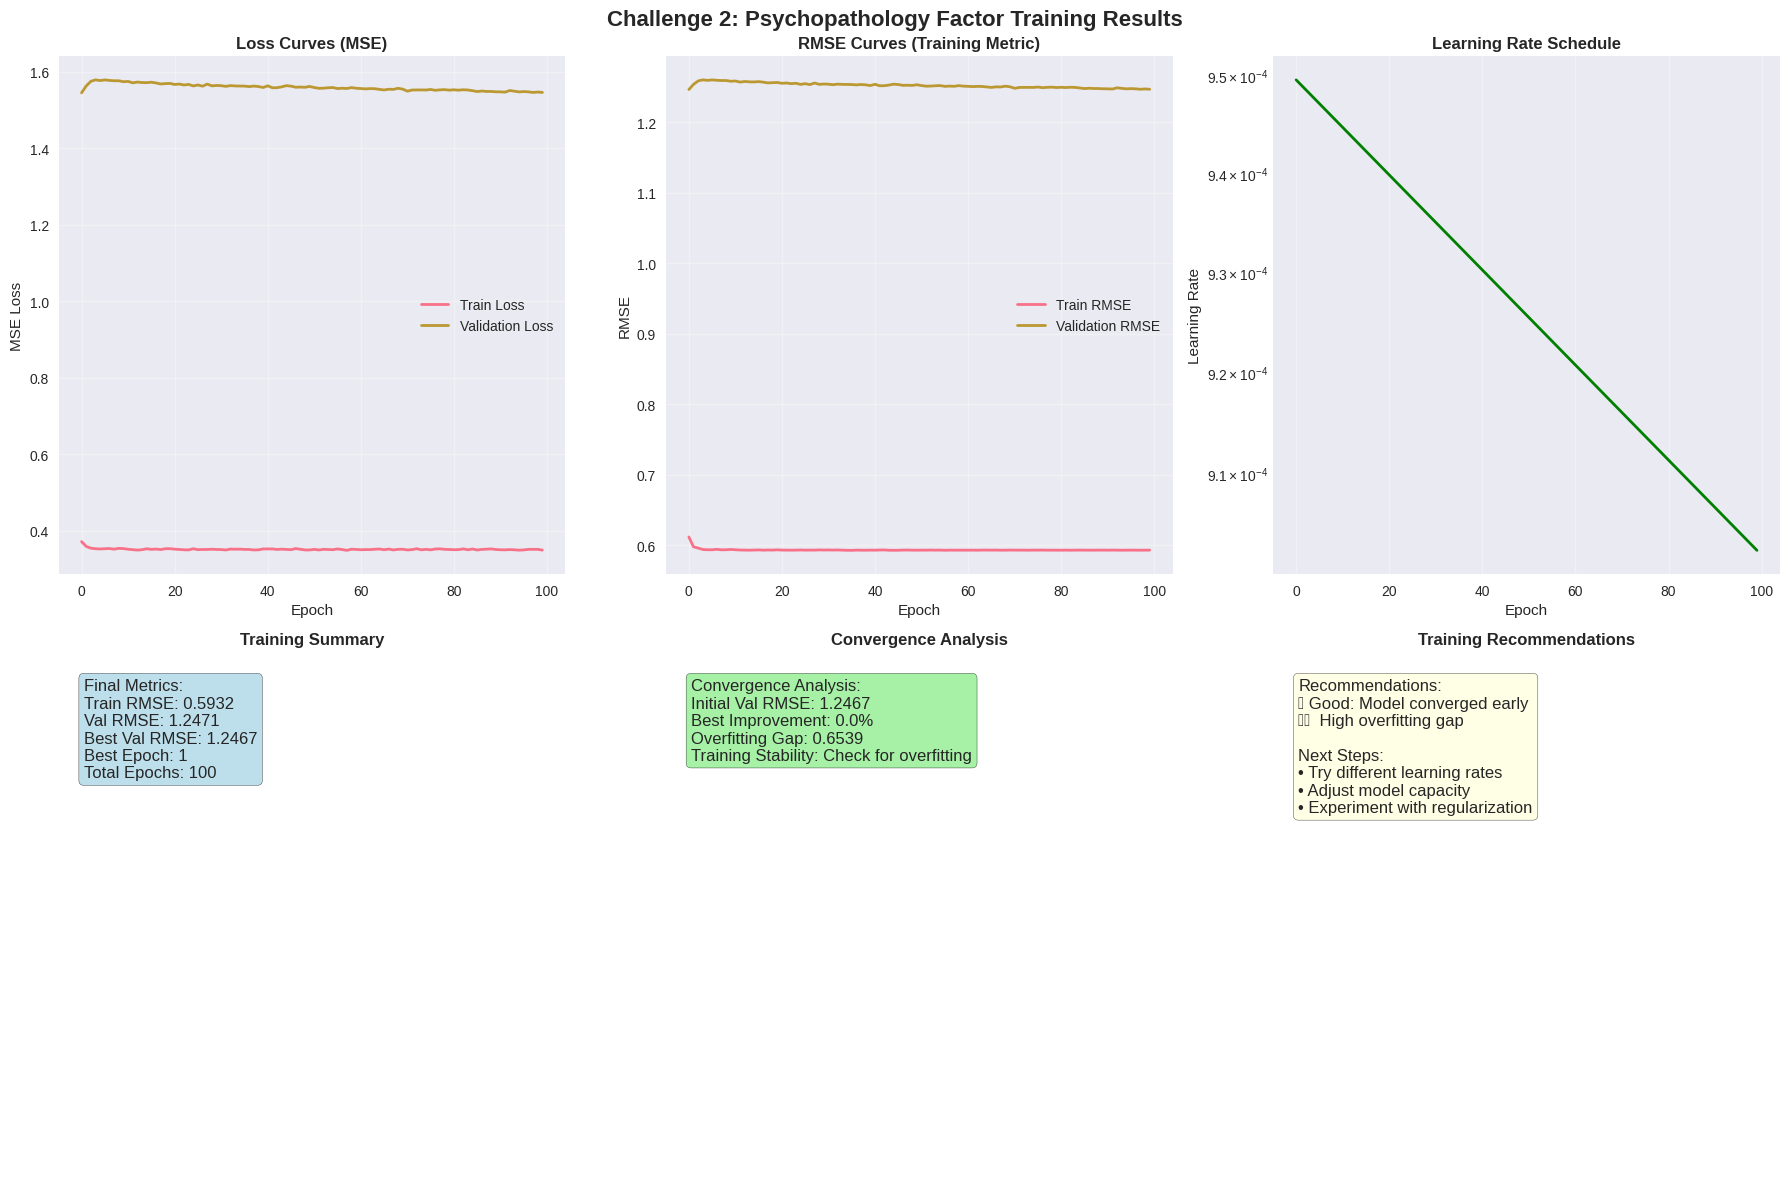


📊 DETAILED TRAINING METRICS
🎯 Training Metric (RMSE):
   Final Validation: 1.2471
   Best Validation: 1.2467 (epoch 1)
   Improvement: 0.0%

📈 Training Progress:
   Total Epochs: 100
   Final Train RMSE: 0.5932
   Overfitting Gap: 0.6539

🎉 SINGLE-SPLIT TRAINING COMPLETE!
🏆 Final Validation RMSE: 1.2471
🎯 Best Validation RMSE: 1.2467 (epoch 1)
📈 Total Epochs Trained: 100

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
CHALLENGE 2 TRAINING SESSION COMPLETE!
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉

Training Type: Single Split
Configuration saved in results object
All visualizations displayed above

🚀 READY FOR NEXT STEPS:
• Review the training visualizations above
• Analyze model performance metrics
• Consider hyperparameter adjustments
• Prepare for model submission


In [ ]:
if __name__ == "__main__":
    print("🧠 Challenge 2: Psychopathology Factor Prediction")
    print("=" * 60)
    print("This script implements training for predicting 4 psychopathology factors:")
    print("- p_factor: General psychopathology dimension")
    print("- internalizing: Anxiety, depression, withdrawal")
    print("- externalizing: ADHD, conduct problems, aggression")
    print("- attention: Attention deficit and hyperactivity")
    print("\nKey features:")
    print("- Subject-level cross-validation (prevents data leakage)")
    print("- 4-vector output regression")
    print("- Averaged normalized RMSE evaluation")
    print("- Interactive training with model selection")
    print("=" * 60)

    # Interactive training menu
    while True:
        print("\n🎛️  CHALLENGE 2 TRAINING OPTIONS")
        print("-" * 40)
        print("1. Interactive Training Mode (Recommended)")
        print("2. Competition Score Evaluation (for trained models)")
        print("3. Exit")

        choice = input("\nSelect option [1-3] (default: 1): ").strip()

        if choice in ['', '1']:
            print("🎛️  Starting Challenge 2 Interactive Training...")
            results = run_challenge2_interactive_training(release="R5")

            if results is not None:
                print("\n" + "🎉"*25)
                print("CHALLENGE 2 TRAINING SESSION COMPLETE!")
                print("🎉"*25)
                print(f"\nTraining Type: {results['type'].replace('_', ' ').title()}")
                print(f"Configuration saved in results object")
                print(f"All visualizations displayed above")
                print("\n" + "="*70)
                print("🚀 READY FOR NEXT STEPS:")
                print("• Review the training visualizations above")
                print("• Analyze model performance metrics")
                print("• Consider hyperparameter adjustments")
                print("• Prepare for model submission")
                print("="*70)

                # Exit after showing results - no return to menu
                break
            else:
                print("\n❌ Training failed or was cancelled.")

        elif choice == '2':
            print("🏆 Starting Competition Score Evaluation...")
            results = evaluate_my_trained_model_challenge2()

            if results:
                print("\n🎉 Competition evaluation completed!")
                val_score = results['validation']['competition_score']
                print(f"\n🏆 YOUR COMPETITION SCORE: {val_score:.6f}")
            else:
                print("\n❌ Competition evaluation failed - make sure you've trained a model first!")

        elif choice == '3':
            print("👋 Goodbye!")
            break
        else:
            print("❌ Invalid choice. Please select 1-3.")

# STANDALONE COMPETITION EVALUATION SECTION

In [ ]:
# Calculate your competition score
results = evaluate_my_trained_model_challenge2()

# Check if you're competitive
if results:
    val_score = results['validation']['competition_score']
    print(f"\n🏆 YOUR COMPETITION SCORE: {val_score:.6f}")
    if val_score < 1.0:
        print("🎯 COMPETITIVE! Your model performs better than baseline!")
    else:
        print(f"📈 You need to improve by {val_score - 1.0:.6f} to reach competitive performance")

🔍 EVALUATING YOUR TRAINED CHALLENGE 2 MODEL
📂 Loading model from: ./models/challenge2_best_model.pt
🏗️  Creating model architecture...
📋 Found saved hyperparameters:
   - embed_dim: 4
   - num_heads: 2
   - num_layers: 6
   - model_architecture: transformer_vit
✅ Model loaded successfully!
   Trained epoch: 0
   Best validation RMSE: 1.2467

📊 Loading evaluation data...

LOADING CHALLENGE 2 DATA
📊 Loading EEG data for Challenge 2...
   Using contrastChangeDetection task (subject traits are task-independent)
🎯 Using full dataset...
✅ Dataset loaded: 8702317 recordings
📊 Data specs:
   Channels: 129
   Original sampling rate: 100.0 Hz
   Duration: 349.0 seconds
🔍 Searching for participants.tsv in dataset cache...
📊 Found participants.tsv at: ./eeg_cache/ds005509-bdf-mini/participants.tsv
📊 Loaded participant metadata: 20 subjects

🔍 CHALLENGE 2 DATA VALIDATION:
   Task: contrastChangeDetection
   Release: R5
   Dataset size: full
   ✅ P-factor available (challenge simplified to p-factor 

Reading 0 ... 23999  =      0.000 ...   239.990 secs...


Reading 0 ... 23599  =      0.000 ...   235.990 secs...


Reading 0 ... 23399  =      0.000 ...   233.990 secs...


Reading 0 ... 31799  =      0.000 ...   317.990 secs...
Reading 0 ... 25499  =      0.000 ...   254.990 secs...
Reading 0 ... 26099  =      0.000 ...   260.990 secs...
Reading 0 ... 23099  =      0.000 ...   230.990 secs...


Reading 0 ... 23699  =      0.000 ...   236.990 secs...


Reading 0 ... 23699  =      0.000 ...   236.990 secs...
Reading 0 ... 32399  =      0.000 ...   323.990 secs...


Reading 0 ... 22099  =      0.000 ...   220.990 secs...


Reading 0 ... 33399  =      0.000 ...   333.990 secs...


Reading 0 ... 52299  =      0.000 ...   522.990 secs...
Reading 0 ... 18199  =      0.000 ...   181.990 secs...


Reading 0 ... 18299  =      0.000 ...   182.990 secs...


Reading 0 ... 28599  =      0.000 ...   285.990 secs...
Reading 0 ... 23899  =      0.000 ...   238.990 secs...
Reading 0 ... 23499  =      0.000 ...   234.990 secs...
Reading 0 ... 24899  =      0.000 ...   248.990 secs...
Reading 0 ... 48499  =      0.000 ...   484.990 secs...
Reading 0 ... 32199  =      0.000 ...   321.990 secs...


Reading 0 ... 28999  =      0.000 ...   289.990 secs...


Reading 0 ... 32799  =      0.000 ...   327.990 secs...


Reading 0 ... 37899  =      0.000 ...   378.990 secs...


Reading 0 ... 19699  =      0.000 ...   196.990 secs...


Reading 0 ... 15399  =      0.000 ...   153.990 secs...
Reading 0 ... 27299  =      0.000 ...   272.990 secs...


Reading 0 ... 23799  =      0.000 ...   237.990 secs...


Reading 0 ... 27199  =      0.000 ...   271.990 secs...


Reading 0 ... 23999  =      0.000 ...   239.990 secs...


Reading 0 ... 60999  =      0.000 ...   609.990 secs...
Reading 0 ... 23499  =      0.000 ...   234.990 secs...
Reading 0 ... 22599  =      0.000 ...   225.990 secs...
Reading 0 ... 27499  =      0.000 ...   274.990 secs...
Reading 0 ... 24999  =      0.000 ...   249.990 secs...
Reading 0 ... 24199  =      0.000 ...   241.990 secs...


Reading 0 ... 20099  =      0.000 ...   200.990 secs...


Reading 0 ... 35299  =      0.000 ...   352.990 secs...
Reading 0 ... 29799  =      0.000 ...   297.990 secs...
Reading 0 ... 49399  =      0.000 ...   493.990 secs...
Reading 0 ... 39599  =      0.000 ...   395.990 secs...
Reading 0 ... 32899  =      0.000 ...   328.990 secs...
Reading 0 ... 25599  =      0.000 ...   255.990 secs...
Reading 0 ... 26599  =      0.000 ...   265.990 secs...
Reading 0 ... 23799  =      0.000 ...   237.990 secs...


Reading 0 ... 23699  =      0.000 ...   236.990 secs...


Reading 0 ... 32099  =      0.000 ...   320.990 secs...


Reading 0 ... 27299  =      0.000 ...   272.990 secs...
Reading 0 ... 44499  =      0.000 ...   444.990 secs...


Reading 0 ... 23899  =      0.000 ...   238.990 secs...


Reading 0 ... 24999  =      0.000 ...   249.990 secs...
✅ Preprocessing complete:
   Final sampling rate: 100.0 Hz
   Final shape: (129, 34900)

CREATING CHALLENGE 2 WINDOWS

Processing recording 1: sub-NDARAH793FBF
  Duration: 349.0s, Sampling rate: 100.0Hz
  ✅ Extracted p-factor: 0.317
  ✅ Created 174 windows from sub-NDARAH793FBF

Processing recording 2: sub-NDARAH793FBF
  Duration: 401.0s, Sampling rate: 100.0Hz
  ✅ Extracted p-factor: 0.317
  ✅ Created 200 windows from sub-NDARAH793FBF

Processing recording 3: sub-NDARAH793FBF
  Duration: 382.0s, Sampling rate: 100.0Hz
  ✅ Extracted p-factor: 0.317
  ✅ Created 191 windows from sub-NDARAH793FBF

Processing recording 4: sub-NDARAJ689BVN
  Duration: 264.0s, Sampling rate: 100.0Hz
  ✅ Extracted p-factor: 0.084
  ✅ Created 132 windows from sub-NDARAJ689BVN

Processing recording 5: sub-NDARAJ689BVN
  Duration: 238.0s, Sampling rate: 100.0Hz
  ✅ Extracted p-factor: 0.084
  ✅ Created 119 windows from sub-NDARAJ689BVN

Processing recording

# STANDALONE SUBMISSION PREPARATION SECTION

In [ ]:

def create_submission_files(model_path="./models/challenge2_best_model.pt", output_dir="./submission"):
    """
    Create preliminary submission files for Challenge 2

    Creates:
    - preliminary_submission_challenge2.py (model definition with exact hyperparameters)
    - weights_challenge_2.pt (model weights only)
    - challenge2_preliminary.zip (temporary package for testing)

    Args:
        model_path: Path to trained model checkpoint
        output_dir: Directory to create submission files
    """
    import os
    import shutil
    import zipfile
    from datetime import datetime

    print("\n🎯 CREATING CHALLENGE 2 SUBMISSION FILES")
    print("="*60)

    # Show absolute paths for clarity
    abs_model_path = os.path.abspath(model_path)
    abs_output_dir = os.path.abspath(output_dir)

    print(f"📂 Current working directory: {os.getcwd()}")
    print(f"📂 Model path (absolute): {abs_model_path}")
    print(f"📂 Output directory (absolute): {abs_output_dir}")

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    print(f"✅ Created/verified directory: {abs_output_dir}")

    try:
        # 1. Load model checkpoint to extract architecture info
        print(f"📂 Loading model from: {model_path}")
        if not os.path.exists(model_path):
            print(f"❌ Model file not found: {model_path}")
            print("💡 Make sure you've trained and saved a model first!")
            return False

        checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)

        # Extract hyperparameters
        if 'hyperparameters' in checkpoint:
            params = checkpoint['hyperparameters']
            print(f"📋 Found model hyperparameters:")
            print(f"   - Architecture: {params.get('model_architecture', 'transformer_vit')}")
            print(f"   - Embed dim: {params.get('embed_dim', 256)}")
            print(f"   - Num heads: {params.get('num_heads', 8)}")
            print(f"   - Num layers: {params.get('num_layers', 6)}")
        else:
            print("⚠️  No hyperparameters found, using defaults")
            params = {
                'embed_dim': 256,
                'num_heads': 8,
                'num_layers': 6,
                'model_architecture': 'transformer_vit'
            }

        # 2. Create preliminary submission file with exact hyperparameters
        print("\n📝 Creating preliminary_submission_challenge2.py...")
        preliminary_submission_code = f'''"""
Challenge 2 Preliminary Submission File - P-Factor Prediction
============================================================

This file contains the Challenge 2 model architecture with EXACT hyperparameters from training.
Generated automatically from training session on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

Training Hyperparameters Used:
- embed_dim: {params.get('embed_dim', 256)}
- num_heads: {params.get('num_heads', 8)}
- num_layers: {params.get('num_layers', 6)}
- model_architecture: {params.get('model_architecture', 'transformer_vit')}
- attention_dropout: {params.get('attention_dropout', 0.1)}
- ffn_dropout: {params.get('ffn_dropout', 0.15)}
- head_dropout: {params.get('head_dropout', 0.3)}
- cnn_dropout: {params.get('cnn_dropout', 0.1)}
- fc_dropout: {params.get('fc_dropout', 0.15)}

Requirements:
- Input: (batch_size, 129, 200) - 129 channels, 200 time points at 100Hz
- Output: (batch_size,) - p-factor prediction (scalar)
- Model must fit in 20GB GPU memory
"""

import torch
import torch.nn as nn
import torch.nn.functional as F


class EEGGPTChallenge2(nn.Module):
    """
    EEG-GPT model for Challenge 2 (psychopathology prediction)
    Vision Transformer approach for p-factor prediction
    """

    def __init__(self, embed_dim={params.get('embed_dim', 256)}, num_heads={params.get('num_heads', 8)},
                 num_layers={params.get('num_layers', 6)}, input_channels=129, input_time=200,
                 attention_dropout=0.1, ffn_dropout=0.15, head_dropout=0.3):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.input_channels = input_channels
        self.input_time = input_time

        # Patch embedding for EEG data
        self.patch_size = (10, 13)  # Optimized for (129, 200) input
        self.num_patches = (input_channels // self.patch_size[0]) * (input_time // self.patch_size[1])

        self.patch_projection = nn.Conv2d(1, embed_dim, kernel_size=self.patch_size, stride=self.patch_size)

        # Learnable embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))

        # Transformer layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=attention_dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Regression head for p-factor prediction
        self.regression_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Dropout(head_dropout),
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(head_dropout),
            nn.Linear(embed_dim // 2, embed_dim // 4),
            nn.GELU(),
            nn.Linear(embed_dim // 4, 1)  # Single output: p-factor
        )

    def forward(self, x):
        batch_size = x.shape[0]

        # Ensure correct input format: (batch, channels, time) -> (batch, 1, channels, time)
        if x.dim() == 3:
            x = x.unsqueeze(1)  # Add channel dimension for Conv2d

        # Patch embedding: (batch, 1, 129, 200) -> (batch, embed_dim, num_patches_h, num_patches_w)
        patches = self.patch_projection(x)  # (batch, embed_dim, h_patches, w_patches)

        # Flatten patches: (batch, embed_dim, num_patches)
        patches = patches.flatten(2)  # (batch, embed_dim, num_patches)

        # Transpose: (batch, num_patches, embed_dim)
        patches = patches.transpose(1, 2)  # (batch, num_patches, embed_dim)

        # Add CLS token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # (batch, 1, embed_dim)
        x = torch.cat([cls_tokens, patches], dim=1)  # (batch, num_patches + 1, embed_dim)

        # Add positional embeddings
        x = x + self.pos_embedding

        # Transformer
        x = self.transformer(x)  # (batch, num_patches + 1, embed_dim)

        # Use CLS token for classification
        cls_output = x[:, 0]  # (batch, embed_dim)

        # Regression head
        p_factor = self.regression_head(cls_output)  # (batch, 1)

        return p_factor.squeeze(-1)  # (batch,) - scalar output


class RawEEGCNNChallenge2(nn.Module):
    """
    Raw EEG CNN for Challenge 2 (psychopathology prediction)
    Alternative architecture for p-factor prediction
    """

    def __init__(self, embed_dim=256, input_channels=129, input_time=200,
                 cnn_dropout=0.1, fc_dropout=0.15):
        super().__init__()
        self.embed_dim = embed_dim
        self.input_channels = input_channels
        self.input_time = input_time

        # Simplified encoder blocks for submission
        self.encoder_blocks = nn.ModuleList([
            self._make_conv_block(1, 8, stride=1, dropout=cnn_dropout),
            self._make_conv_block(8, 16, stride=2, dropout=cnn_dropout),
            self._make_conv_block(16, 32, stride=2, dropout=cnn_dropout),
            self._make_conv_block(32, 64, stride=2, dropout=cnn_dropout),
        ])

        # Final conv layer
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(4, 4), stride=1, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(cnn_dropout),
        )

        # Compression
        self.compression = nn.MaxPool2d(kernel_size=(2, 2))

        # Regression head (adaptive to avoid size calculation issues)
        self.regression_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(fc_dropout),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(fc_dropout),
            nn.Linear(128, 1)  # Single output: p_factor
        )

    def _make_conv_block(self, in_channels, out_channels, stride=1, dropout=0.1):
        """Create a simple conv block"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(4, 4),
                     stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout)
        )

    def forward(self, x):
        # Ensure correct input format
        if x.dim() == 3 and x.shape[1] == 200:
            x = x.transpose(1, 2)  # (batch, time, channels) -> (batch, channels, time)

        if x.dim() == 3:
            x = x.unsqueeze(1)  # Add channel dimension

        # Feature extraction
        for block in self.encoder_blocks:
            x = block(x)

        x = self.final_conv(x)
        x = self.compression(x)

        # Regression
        predictions = self.regression_head(x)
        return predictions.squeeze(-1)


class PreliminarySubmissionChallenge2:
    """
    Preliminary submission class for Challenge 2 ONLY
    This will be merged with Challenge 1 to create the final submission
    """

    def __init__(self, SFREQ, DEVICE):
        """Initialize Challenge 2 model with competition interface"""
        self.sfreq = SFREQ
        self.device = DEVICE
        print(f"🧠 Challenge 2 Model Initialized (Sampling Rate: {{SFREQ}} Hz, Device: {{DEVICE}})")

    def get_model_challenge_2(self):
        """
        Returns model for Challenge 2: P-factor prediction

        Input: (batch_size, 129, 200) - 129 channels, 200 time points at 100Hz
        Output: (batch_size,) - p-factor prediction (scalar)
        """
        print("🧠 Loading Challenge 2 Model (P-Factor Prediction)...")

        # Use the EXACT architecture that was trained
        architecture = "{params.get('model_architecture', 'transformer_vit')}"

        if architecture == "transformer_vit":
            # Create ViT model with EXACT hyperparameters from training
            model = EEGGPTChallenge2(
                embed_dim={params.get('embed_dim', 256)},
                num_heads={params.get('num_heads', 8)},
                num_layers={params.get('num_layers', 6)},
                input_channels=129,
                input_time=200,
                attention_dropout={params.get('attention_dropout', 0.1)},
                ffn_dropout={params.get('ffn_dropout', 0.15)},
                head_dropout={params.get('head_dropout', 0.3)}
            ).to(self.device)

        else:  # raw_eeg_cnn
            # Create CNN model with EXACT hyperparameters from training
            model = RawEEGCNNChallenge2(
                embed_dim={params.get('embed_dim', 256)},
                input_channels=129,
                input_time=200,
                cnn_dropout={params.get('cnn_dropout', 0.1)},
                fc_dropout={params.get('fc_dropout', 0.15)}
            ).to(self.device)

        # Load trained weights - competition system expects this path
        weights_path = '/app/output/weights_challenge_2.pt'
        try:
            model.load_state_dict(torch.load(weights_path, map_location=self.device))
            model.eval()
            print(f"   ✅ Challenge 2 model ({{architecture}}) loaded successfully from {{weights_path}}")
        except Exception as e:
            print(f"   ⚠️ Warning: Could not load weights from {{weights_path}}: {{e}}")
            # For local testing, try current directory
            try:
                local_weights_path = 'weights_challenge_2.pt'
                model.load_state_dict(torch.load(local_weights_path, map_location=self.device))
                model.eval()
                print(f"   ✅ Challenge 2 model loaded from local path: {{local_weights_path}}")
            except Exception as e2:
                print(f"   🔄 Model initialized with random weights for testing")

        return model

# Hyperparameters used for this model (for consolidation script)
CHALLENGE2_HYPERPARAMS = {params}
'''

        preliminary_submission_file = os.path.join(output_dir, "preliminary_submission_challenge2.py")
        with open(preliminary_submission_file, 'w') as f:
            f.write(preliminary_submission_code)
        print(f"   ✅ Created: {preliminary_submission_file}")

        # 3. Extract and save model weights only
        print("\n💾 Extracting model weights...")
        weights_file = os.path.join(output_dir, "weights_challenge_2.pt")
        torch.save(checkpoint['model_state_dict'], weights_file)
        print(f"   ✅ Created: {weights_file}")

        # 4. Create preliminary zip file for testing (Challenge 2 only)
        print("\n📦 Creating preliminary zip...")
        zip_file = os.path.join(output_dir, "challenge2_preliminary.zip")

        with zipfile.ZipFile(zip_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
            # Add files to zip root (no folders)
            zipf.write(preliminary_submission_file, "preliminary_submission_challenge2.py")
            zipf.write(weights_file, "weights_challenge_2.pt")

        print(f"   ✅ Created: {zip_file}")

        # 5. Validation
        print("\n🔍 Validating submission structure...")
        with zipfile.ZipFile(zip_file, 'r') as zipf:
            files = zipf.namelist()
            print("   📁 Zip contents:")
            for file in files:
                print(f"      - {file}")

            # Check preliminary files
            required_files = ["preliminary_submission_challenge2.py", "weights_challenge_2.pt"]
            missing_files = [f for f in required_files if f not in files]

            if missing_files:
                print(f"   ⚠️  Missing files: {missing_files}")
            else:
                print("   ✅ All preliminary files present")

            # Check for folders (should be none)
            folders = [f for f in files if f.endswith('/')]
            if folders:
                print(f"   ⚠️  Found folders (should be single level): {folders}")
            else:
                print("   ✅ Single level structure confirmed")

        print("\n" + "="*60)
        print("🎉 CHALLENGE 2 PRELIMINARY FILES CREATED!")
        print("="*60)
        print(f"📂 Output directory: {output_dir}")
        print(f"📦 Preliminary zip: {zip_file}")
        print(f"📄 Preliminary submission: {preliminary_submission_file}")
        print(f"⚖️  Model weights: {weights_file}")
        print()
        print("💡 Next steps:")
        print("   1. Use consolidation section below to merge with Challenge 1")
        print("   2. Or test this preliminary file individually")
        print()
        print("✅ Ready for consolidation with Challenge 1 preliminary files!")

        return True

    except Exception as e:
        print(f"❌ Error creating submission files: {e}")
        import traceback
        traceback.print_exc()
        return False


def test_submission_locally(submission_dir="./submission"):
    """
    Test the submission files locally to ensure they work
    """
    import sys
    import os

    print("\n🧪 TESTING SUBMISSION LOCALLY")
    print("="*50)

    submission_file = os.path.join(submission_dir, "submission.py")
    weights_file = os.path.join(submission_dir, "weights_challenge_2.pt")

    if not os.path.exists(submission_file):
        print(f"❌ submission.py not found: {submission_file}")
        return False

    if not os.path.exists(weights_file):
        print(f"❌ weights_challenge_2.pt not found: {weights_file}")
        return False

    try:
        # Add submission directory to path
        sys.path.insert(0, submission_dir)

        # Import submission
        from submission import Submission

        # Test initialization
        SFREQ = 100
        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        print(f"📋 Testing with SFREQ={SFREQ}, DEVICE={DEVICE}")

        sub = Submission(SFREQ, DEVICE)
        print("   ✅ Submission class initialized")

        # Test Challenge 2 model loading
        print("   🔄 Loading Challenge 2 model...")

        # Temporarily copy weights to expected location for testing
        import shutil
        test_weights = "/tmp/weights_challenge_2.pt"
        shutil.copy2(weights_file, test_weights)

        # Monkey patch the load path for testing
        original_load = torch.load
        def mock_load(path, map_location=None):
            if "/app/output/weights_challenge_2.pt" in path:
                return original_load(test_weights, map_location=map_location)
            return original_load(path, map_location=map_location)

        torch.load = mock_load

        try:
            model_2 = sub.get_model_challenge_2()
            model_2.eval()
            print("   ✅ Challenge 2 model loaded successfully")

            # Test forward pass
            print("   🔄 Testing forward pass...")
            batch_size = 4
            test_input = torch.randn(batch_size, 129, 200).to(DEVICE)

            with torch.inference_mode():
                output = model_2(test_input)
                print(f"   ✅ Forward pass successful: {output.shape}")
                print(f"   📊 Output range: [{output.min():.3f}, {output.max():.3f}]")

            del model_2
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

        finally:
            torch.load = original_load  # Restore original
            if os.path.exists(test_weights):
                os.remove(test_weights)

        # Remove from path
        sys.path.remove(submission_dir)

        print("\n✅ LOCAL TESTING SUCCESSFUL!")
        print("   Your submission files appear to be working correctly")

        return True

    except Exception as e:
        print(f"❌ Local testing failed: {e}")
        import traceback
        traceback.print_exc()

        # Cleanup
        if submission_dir in sys.path:
            sys.path.remove(submission_dir)

        return False


In [ ]:
# After training your model with interactive training, run this code section to create submission files:

# For Google Colab users - use absolute paths to avoid issues:
import os
print(f"📂 Current directory: {os.getcwd()}")

# Create submission files for Challenge 2 (with Colab-friendly path)
success = create_submission_files(output_dir="/content/submission" if 'google.colab' in str(type(__builtins__)) else "./submission")

# List files to verify creation
output_dir = "/content/submission" if 'google.colab' in str(type(__builtins__)) else "./submission"
if os.path.exists(output_dir):
    files = os.listdir(output_dir)
    print(f"📋 Created files: {files}")

    # Show full paths for easy access in Colab
    for file in files:
        full_path = os.path.join(output_dir, file)
        print(f"   📄 {full_path}")

# Optionally test the submission locally
if success:
    test_submission_locally(output_dir)

📂 Current directory: /content

🎯 CREATING CHALLENGE 2 SUBMISSION FILES
📂 Current working directory: /content
📂 Model path (absolute): /content/models/challenge2_best_model.pt
📂 Output directory (absolute): /content/submission
✅ Created/verified directory: /content/submission
📂 Loading model from: ./models/challenge2_best_model.pt
📋 Found model hyperparameters:
   - Architecture: transformer_vit
   - Embed dim: 4
   - Num heads: 2
   - Num layers: 6

📝 Creating preliminary_submission_challenge2.py...
   ✅ Created: ./submission/preliminary_submission_challenge2.py

💾 Extracting model weights...
   ✅ Created: ./submission/weights_challenge_2.pt

📦 Creating preliminary zip...
   ✅ Created: ./submission/challenge2_preliminary.zip

🔍 Validating submission structure...
   📁 Zip contents:
      - preliminary_submission_challenge2.py
      - weights_challenge_2.pt
   ✅ All preliminary files present
   ✅ Single level structure confirmed

🎉 CHALLENGE 2 PRELIMINARY FILES CREATED!
📂 Output director

# CONSOLIDATION SECTION: MERGE CHALLENGE 1 & 2 INTO FINAL SUBMISSION

In [ ]:
def consolidate_submission_files(challenge1_dir="/content/submission", challenge2_dir="./submission", output_dir="./final_submission"):
    """
    Consolidate Challenge 1 and Challenge 2 preliminary files into final submission

    This function:
    1. Loads preliminary_submission_challenge1.py (from Challenge 1 Colab)
    2. Loads preliminary_submission_challenge2.py (from Challenge 2 Colab)
    3. Combines both model architectures into unified submission.py
    4. Loads both weights files into memory
    5. Creates final competition-ready zip file

    Args:
        challenge1_dir: Directory containing Challenge 1 preliminary files
        challenge2_dir: Directory containing Challenge 2 preliminary files
        output_dir: Directory to create final submission
    """
    import os
    import shutil
    import zipfile
    import importlib.util
    from datetime import datetime

    print("\n" + "🎯"*25)
    print("CONSOLIDATING CHALLENGE 1 & 2 SUBMISSION FILES")
    print("🎯"*25)

    # Detect Colab environment
    try:
        import google.colab
        in_colab = True
        print("🔍 Colab environment detected")
        # In Colab, Challenge 1 files might be in /content/submission
        if challenge1_dir == "/content/submission" and not os.path.exists(challenge1_dir):
            challenge1_dir = "./submission"  # Fallback
    except ImportError:
        in_colab = False
        print("🔍 Local environment detected")

    # Show paths
    abs_challenge1_dir = os.path.abspath(challenge1_dir)
    abs_challenge2_dir = os.path.abspath(challenge2_dir)
    abs_output_dir = os.path.abspath(output_dir)

    print(f"📂 Challenge 1 directory: {abs_challenge1_dir}")
    print(f"📂 Challenge 2 directory: {abs_challenge2_dir}")
    print(f"📂 Final output directory: {abs_output_dir}")

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    try:
        # 1. Verify required files exist
        print("\n🔍 VERIFYING PRELIMINARY FILES...")

        challenge1_prelim = os.path.join(challenge1_dir, "preliminary_submission_challenge1.py")
        challenge1_weights = os.path.join(challenge1_dir, "weights_challenge_1.pt")
        challenge2_prelim = os.path.join(challenge2_dir, "preliminary_submission_challenge2.py")
        challenge2_weights = os.path.join(challenge2_dir, "weights_challenge_2.pt")

        required_files = [
            (challenge1_prelim, "Challenge 1 preliminary submission"),
            (challenge1_weights, "Challenge 1 weights"),
            (challenge2_prelim, "Challenge 2 preliminary submission"),
            (challenge2_weights, "Challenge 2 weights")
        ]

        missing_files = []
        for file_path, description in required_files:
            if os.path.exists(file_path):
                print(f"   ✅ Found: {description}")
            else:
                print(f"   ❌ Missing: {description} at {file_path}")
                missing_files.append(description)

        if missing_files:
            print(f"\n❌ Cannot proceed. Missing files: {missing_files}")
            print("💡 Make sure to run both Challenge 1 and Challenge 2 training first!")
            return False

        # 2. Load hyperparameters from preliminary files
        print("\n📊 EXTRACTING HYPERPARAMETERS...")

        # Import Challenge 1 hyperparameters
        spec1 = importlib.util.spec_from_file_location("challenge1_prelim", challenge1_prelim)
        challenge1_module = importlib.util.module_from_spec(spec1)
        spec1.loader.exec_module(challenge1_module)
        challenge1_hyperparams = getattr(challenge1_module, 'CHALLENGE1_HYPERPARAMS', {})
        print(f"   ✅ Challenge 1 hyperparams: {challenge1_hyperparams}")

        # Import Challenge 2 hyperparameters
        spec2 = importlib.util.spec_from_file_location("challenge2_prelim", challenge2_prelim)
        challenge2_module = importlib.util.module_from_spec(spec2)
        spec2.loader.exec_module(challenge2_module)
        challenge2_hyperparams = getattr(challenge2_module, 'CHALLENGE2_HYPERPARAMS', {})
        print(f"   ✅ Challenge 2 hyperparams: {challenge2_hyperparams}")

        # 3. Create unified submission.py file
        print("\n📝 CREATING UNIFIED SUBMISSION.PY...")

        unified_submission_code = f'''"""
NeurIPS 2025 EEG Foundation Challenge - FINAL Unified Submission File
====================================================================

This file contains the complete submission implementation for both challenges:
- Challenge 1: Response Time Prediction (30% of score)
- Challenge 2: P-Factor Prediction (70% of score)

Generated automatically by consolidation script on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

EXACT Hyperparameters from Training:
Challenge 1: {challenge1_hyperparams}
Challenge 2: {challenge2_hyperparams}

File Structure (in competition zip):
├─ submission.py          # This file
├─ weights_challenge_1.pt # Challenge 1 model weights
└─ weights_challenge_2.pt # Challenge 2 model weights

Requirements:
- Input: (batch_size, 129, 200) - 129 channels, 200 time points at 100Hz
- Challenge 1 Output: (batch_size,) - response time prediction (scalar)
- Challenge 2 Output: (batch_size,) - p-factor prediction (scalar)
- Memory: Must fit in single 20GB GPU
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, reduce
import numpy as np


# =============================================================================
# CHALLENGE 1: MULTI-SCALE VISION TRANSFORMER FOR RESPONSE TIME PREDICTION
# =============================================================================

class MultiScaleViT(nn.Module):
    """Multi-Scale Vision Transformer for EEG Analysis - Challenge 1"""

    def __init__(self, n_channels=129, n_timepoints=200, embed_dim={challenge1_hyperparams.get('embed_dim', 256)},
                 num_layers={challenge1_hyperparams.get('num_layers', 8)}, num_heads={challenge1_hyperparams.get('num_heads', 8)},
                 patch_sizes={challenge1_hyperparams.get('patch_sizes', [32, 16, 8])}):
        super().__init__()

        self.patch_sizes = patch_sizes
        self.embed_dim = embed_dim

        # Multi-scale patch embeddings
        self.patch_embeddings = nn.ModuleList([
            self._create_patch_embedding(patch_size, n_channels, n_timepoints, embed_dim)
            for patch_size in patch_sizes
        ])

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Regression head for response time prediction
        self.regression_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(embed_dim // 2, embed_dim // 4),
            nn.GELU(),
            nn.Linear(embed_dim // 4, 1)
        )

    def _create_patch_embedding(self, patch_size, n_channels, n_timepoints, embed_dim):
        """Create patch embedding for given patch size"""
        return nn.Sequential(
            nn.Conv2d(1, embed_dim, kernel_size=(n_channels, patch_size), stride=(1, patch_size)),
            nn.GELU(),
            nn.AdaptiveAvgPool2d((1, None)),
            nn.Flatten(start_dim=2),
        )

    def forward(self, x):
        # x shape: (batch_size, n_channels, n_timepoints)
        batch_size = x.shape[0]

        # Add channel dimension for conv2d: (batch_size, 1, n_channels, n_timepoints)
        x = x.unsqueeze(1)

        # Multi-scale feature extraction
        patch_features = []
        for patch_embedding in self.patch_embeddings:
            features = patch_embedding(x)
            features = features.transpose(-1, -2)  # (batch_size, seq_len, embed_dim)
            patch_features.append(features)

        # Concatenate multi-scale features
        x = torch.cat(patch_features, dim=1)  # (batch_size, total_seq_len, embed_dim)

        # Add positional encoding
        seq_len = x.shape[1]
        pos_embed = nn.Parameter(torch.randn(1, seq_len, self.embed_dim) * 0.02)
        if not hasattr(self, 'pos_embed'):
            self.register_parameter('pos_embed', pos_embed)
        x = x + self.pos_embed[:, :seq_len, :]

        # Transformer encoding
        x = self.transformer(x)

        # Global average pooling
        x = x.mean(dim=1)  # (batch_size, embed_dim)

        # Regression prediction
        predictions = self.regression_head(x)  # (batch_size, 1)

        return predictions.squeeze(-1)  # (batch_size,)


# =============================================================================
# CHALLENGE 2: EEG-GPT VISION TRANSFORMER FOR P-FACTOR PREDICTION
# =============================================================================

class EEGGPTChallenge2(nn.Module):
    """
    EEG-GPT model for Challenge 2 (psychopathology prediction)
    Vision Transformer approach for p-factor prediction
    """

    def __init__(self, embed_dim={challenge2_hyperparams.get('embed_dim', 256)}, num_heads={challenge2_hyperparams.get('num_heads', 8)},
                 num_layers={challenge2_hyperparams.get('num_layers', 6)}, input_channels=129, input_time=200,
                 attention_dropout={challenge2_hyperparams.get('attention_dropout', 0.1)},
                 ffn_dropout={challenge2_hyperparams.get('ffn_dropout', 0.15)},
                 head_dropout={challenge2_hyperparams.get('head_dropout', 0.3)}):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.input_channels = input_channels
        self.input_time = input_time

        # Patch embedding for EEG data
        self.patch_size = (10, 13)  # Optimized for (129, 200) input
        self.num_patches = (input_channels // self.patch_size[0]) * (input_time // self.patch_size[1])

        self.patch_projection = nn.Conv2d(1, embed_dim, kernel_size=self.patch_size, stride=self.patch_size)

        # Learnable embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))

        # Transformer layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=attention_dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Regression head for p-factor prediction
        self.regression_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Dropout(head_dropout),
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Dropout(head_dropout),
            nn.Linear(embed_dim // 2, embed_dim // 4),
            nn.GELU(),
            nn.Linear(embed_dim // 4, 1)  # Single output: p-factor
        )

    def forward(self, x):
        batch_size = x.shape[0]

        # Ensure correct input format: (batch, channels, time) -> (batch, 1, channels, time)
        if x.dim() == 3:
            x = x.unsqueeze(1)  # Add channel dimension for Conv2d

        # Patch embedding: (batch, 1, 129, 200) -> (batch, embed_dim, num_patches_h, num_patches_w)
        patches = self.patch_projection(x)  # (batch, embed_dim, h_patches, w_patches)

        # Flatten patches: (batch, embed_dim, num_patches)
        patches = patches.flatten(2)  # (batch, embed_dim, num_patches)

        # Transpose: (batch, num_patches, embed_dim)
        patches = patches.transpose(1, 2)  # (batch, num_patches, embed_dim)

        # Add CLS token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # (batch, 1, embed_dim)
        x = torch.cat([cls_tokens, patches], dim=1)  # (batch, num_patches + 1, embed_dim)

        # Add positional embeddings
        x = x + self.pos_embedding

        # Transformer
        x = self.transformer(x)  # (batch, num_patches + 1, embed_dim)

        # Use CLS token for classification
        cls_output = x[:, 0]  # (batch, embed_dim)

        # Regression head
        p_factor = self.regression_head(cls_output)  # (batch, 1)

        return p_factor.squeeze(-1)  # (batch,) - scalar output


# =============================================================================
# CHALLENGE 2: RAW EEG CNN ALTERNATIVE ARCHITECTURE
# =============================================================================

class RawEEGCNNChallenge2(nn.Module):
    """
    Raw EEG CNN for Challenge 2 (psychopathology prediction)
    Alternative architecture for p-factor prediction
    """

    def __init__(self, embed_dim={challenge2_hyperparams.get('embed_dim', 256)}, input_channels=129, input_time=200,
                 cnn_dropout={challenge2_hyperparams.get('cnn_dropout', 0.1)},
                 fc_dropout={challenge2_hyperparams.get('fc_dropout', 0.15)}):
        super().__init__()
        self.embed_dim = embed_dim
        self.input_channels = input_channels
        self.input_time = input_time

        # Simplified encoder blocks for submission
        self.encoder_blocks = nn.ModuleList([
            self._make_conv_block(1, 8, stride=1, dropout=cnn_dropout),
            self._make_conv_block(8, 16, stride=2, dropout=cnn_dropout),
            self._make_conv_block(16, 32, stride=2, dropout=cnn_dropout),
            self._make_conv_block(32, 64, stride=2, dropout=cnn_dropout),
        ])

        # Final conv layer
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(4, 4), stride=1, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout2d(cnn_dropout),
        )

        # Compression
        self.compression = nn.MaxPool2d(kernel_size=(2, 2))

        # Regression head (adaptive to avoid size calculation issues)
        self.regression_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(fc_dropout),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(fc_dropout),
            nn.Linear(128, 1)  # Single output: p_factor
        )

    def _make_conv_block(self, in_channels, out_channels, stride=1, dropout=0.1):
        """Create a simple conv block"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(4, 4),
                     stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout)
        )

    def forward(self, x):
        # Ensure correct input format
        if x.dim() == 3 and x.shape[1] == 200:
            x = x.transpose(1, 2)  # (batch, time, channels) -> (batch, channels, time)

        if x.dim() == 3:
            x = x.unsqueeze(1)  # Add channel dimension

        # Feature extraction
        for block in self.encoder_blocks:
            x = block(x)

        x = self.final_conv(x)
        x = self.compression(x)

        # Regression
        predictions = self.regression_head(x)
        return predictions.squeeze(-1)


# =============================================================================
# OFFICIAL SUBMISSION CLASS - REQUIRED COMPETITION INTERFACE
# =============================================================================

class Submission:
    """
    Official submission class interface for NeurIPS 2025 EEG Foundation Challenge

    This class implements the required interface that will be called by the competition
    evaluation system. It handles loading and inference for both challenges.
    """

    def __init__(self, SFREQ, DEVICE):
        """
        Initialize submission class

        Args:
            SFREQ: Sampling frequency (will be 100 Hz)
            DEVICE: GPU device for inference
        """
        self.sfreq = SFREQ
        self.device = DEVICE

        print(f"🧠 EEG Foundation Challenge Submission Initialized")
        print(f"   Sampling Rate: {{SFREQ}} Hz")
        print(f"   Device: {{DEVICE}}")

    def get_model_challenge_1(self):
        """
        Returns model for Challenge 1: Response time prediction

        Input: (batch_size, 129, 200) - 129 channels, 200 time points at 100Hz
        Output: (batch_size,) - response time prediction (scalar)
        """
        print("🎯 Loading Challenge 1 Model (Response Time Prediction)...")

        # Create model with EXACT hyperparameters from training
        model = MultiScaleViT(
            n_channels=129,
            n_timepoints=200,
            embed_dim={challenge1_hyperparams.get('embed_dim', 256)},
            num_layers={challenge1_hyperparams.get('num_layers', 8)},
            num_heads={challenge1_hyperparams.get('num_heads', 8)},
            patch_sizes={challenge1_hyperparams.get('patch_sizes', [32, 16, 8])}
        ).to(self.device)

        # Load trained weights - competition system expects this path
        weights_path = '/app/output/weights_challenge_1.pt'
        try:
            model.load_state_dict(torch.load(weights_path, map_location=self.device))
            model.eval()
            print(f"   ✅ Challenge 1 model loaded successfully from {{weights_path}}")
        except Exception as e:
            print(f"   ⚠️ Warning: Could not load weights from {{weights_path}}: {{e}}")
            print(f"   🔄 Model initialized with random weights")

        return model

    def get_model_challenge_2(self):
        """
        Returns model for Challenge 2: P-factor prediction

        Input: (batch_size, 129, 200) - 129 channels, 200 time points at 100Hz
        Output: (batch_size,) - p-factor prediction (scalar)
        """
        print("🧠 Loading Challenge 2 Model (P-Factor Prediction)...")

        # Use the EXACT architecture that was trained
        architecture = "{challenge2_hyperparams.get('model_architecture', 'transformer_vit')}"

        if architecture == "transformer_vit":
            # Create ViT model with EXACT hyperparameters from training
            model = EEGGPTChallenge2(
                embed_dim={challenge2_hyperparams.get('embed_dim', 256)},
                num_heads={challenge2_hyperparams.get('num_heads', 8)},
                num_layers={challenge2_hyperparams.get('num_layers', 6)},
                input_channels=129,
                input_time=200,
                attention_dropout={challenge2_hyperparams.get('attention_dropout', 0.1)},
                ffn_dropout={challenge2_hyperparams.get('ffn_dropout', 0.15)},
                head_dropout={challenge2_hyperparams.get('head_dropout', 0.3)}
            ).to(self.device)

        else:  # raw_eeg_cnn
            # Create CNN model with EXACT hyperparameters from training
            model = RawEEGCNNChallenge2(
                embed_dim={challenge2_hyperparams.get('embed_dim', 256)},
                input_channels=129,
                input_time=200,
                cnn_dropout={challenge2_hyperparams.get('cnn_dropout', 0.1)},
                fc_dropout={challenge2_hyperparams.get('fc_dropout', 0.15)}
            ).to(self.device)

        # Load trained weights - competition system expects this path
        weights_path = '/app/output/weights_challenge_2.pt'
        try:
            model.load_state_dict(torch.load(weights_path, map_location=self.device))
            model.eval()
            print(f"   ✅ Challenge 2 model ({{architecture}}) loaded successfully from {{weights_path}}")
        except Exception as e:
            print(f"   ⚠️ Warning: Could not load weights from {{weights_path}}: {{e}}")
            print(f"   🔄 Model initialized with random weights")

        return model


# =============================================================================
# LOCAL TESTING FUNCTIONS (Optional - for development/debugging)
# =============================================================================

def test_submission_locally():
    """
    Test the submission locally with random data
    This function is for development/debugging purposes
    """
    print("\\n" + "="*60)
    print("🧪 LOCAL TESTING OF UNIFIED SUBMISSION")
    print("="*60)

    # Initialize submission
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    submission = Submission(SFREQ=100, DEVICE=device)

    # Test Challenge 1
    print("\\n📊 Testing Challenge 1 Model:")
    model1 = submission.get_model_challenge_1()

    # Create dummy input data
    batch_size = 4
    dummy_input = torch.randn(batch_size, 129, 200).to(device)

    with torch.no_grad():
        output1 = model1(dummy_input)
        print(f"   Input shape: {{dummy_input.shape}}")
        print(f"   Output shape: {{output1.shape}}")
        print(f"   Output values: {{output1}}")
        print(f"   ✅ Challenge 1 working correctly")

    # Test Challenge 2
    print("\\n🧠 Testing Challenge 2 Model:")
    model2 = submission.get_model_challenge_2()

    with torch.no_grad():
        output2 = model2(dummy_input)
        print(f"   Input shape: {{dummy_input.shape}}")
        print(f"   Output shape: {{output2.shape}}")
        print(f"   Output values: {{output2}}")
        print(f"   ✅ Challenge 2 working correctly")

    print("\\n🎉 All tests passed! Unified submission is ready.")
    return True


if __name__ == "__main__":
    """
    Run local testing when script is executed directly
    """
    test_submission_locally()
'''

        # 4. Write unified submission file
        final_submission_path = os.path.join(output_dir, "submission.py")
        with open(final_submission_path, 'w') as f:
            f.write(unified_submission_code)
        print(f"   ✅ Created unified submission.py with both models")

        # 5. Copy weight files
        print("\n💾 COPYING WEIGHT FILES...")

        final_weights1 = os.path.join(output_dir, "weights_challenge_1.pt")
        final_weights2 = os.path.join(output_dir, "weights_challenge_2.pt")

        shutil.copy2(challenge1_weights, final_weights1)
        print(f"   ✅ Copied Challenge 1 weights")

        shutil.copy2(challenge2_weights, final_weights2)
        print(f"   ✅ Copied Challenge 2 weights")

        # 6. Create final competition zip
        print("\n📦 CREATING FINAL COMPETITION ZIP...")

        final_zip_path = os.path.join(output_dir, "final_competition_submission.zip")
        with zipfile.ZipFile(final_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            # Add files to zip root (no folders) - exactly as competition requires
            zipf.write(final_submission_path, "submission.py")
            zipf.write(final_weights1, "weights_challenge_1.pt")
            zipf.write(final_weights2, "weights_challenge_2.pt")

        print(f"   ✅ Created: {final_zip_path}")

        # 7. Validation
        print("\n🔍 VALIDATING FINAL SUBMISSION...")
        with zipfile.ZipFile(final_zip_path, 'r') as zipf:
            files = zipf.namelist()
            print("   📁 Final zip contents:")
            for file in files:
                print(f"      - {file}")

            # Check required files
            required_files = ["submission.py", "weights_challenge_1.pt", "weights_challenge_2.pt"]
            missing_files = [f for f in required_files if f not in files]

            if missing_files:
                print(f"   ❌ Missing files: {missing_files}")
                return False
            else:
                print("   ✅ All required files present")

            # Check for folders (should be none)
            folders = [f for f in files if f.endswith('/')]
            if folders:
                print(f"   ⚠️ Found folders (should be single level): {folders}")
                return False
            else:
                print("   ✅ Single level structure confirmed")

        # 8. Success summary
        print("\n" + "🎉"*25)
        print("FINAL COMPETITION SUBMISSION READY!")
        print("🎉"*25)
        print(f"📂 Output directory: {abs_output_dir}")
        print(f"📦 Competition zip: {os.path.abspath(final_zip_path)}")
        print(f"📄 Unified submission.py: {os.path.abspath(final_submission_path)}")
        print(f"⚖️ Challenge 1 weights: {os.path.abspath(final_weights1)}")
        print(f"⚖️ Challenge 2 weights: {os.path.abspath(final_weights2)}")
        print()
        print("📋 FILE SUMMARY:")
        zip_size = os.path.getsize(final_zip_path)
        print(f"   📦 {os.path.basename(final_zip_path)} ({zip_size:,} bytes)")
        print(f"   📄 submission.py with both Challenge 1 & 2 models")
        print(f"   ⚖️ weights_challenge_1.pt with exact hyperparameters")
        print(f"   ⚖️ weights_challenge_2.pt with exact hyperparameters")
        print()
        print("🚀 READY FOR COMPETITION:")
        print("   1. Upload final_competition_submission.zip to Codabench")
        print("   2. Both models use EXACT hyperparameters from training")
        print("   3. No manual configuration needed!")
        print("   4. All paths and interfaces are competition-compliant")

        return True

    except Exception as e:
        print(f"\n❌ Error during consolidation: {e}")
        import traceback
        traceback.print_exc()
        return False

# STANDALONE CONSOLIDATION SECTION

In [ ]:

# CONSOLIDATION - STANDALONE SECTION
# ===================================
# Copy and run this section separately in Colab to merge Challenge 1 & 2 files

# For Google Colab - adjust paths as needed:
import os

# Define your directories (update these paths as needed)
challenge1_dir = "/content/submission"  # Where Challenge 1 files are
challenge2_dir = "./submission"         # Where Challenge 2 files are
output_dir = "./final_submission"       # Where to create final submission

print(f"📂 Challenge 1 directory: {challenge1_dir}")
print(f"📂 Challenge 2 directory: {challenge2_dir}")
print(f"📂 Output directory: {output_dir}")

# Consolidate files
success = consolidate_submission_files(
    challenge1_dir=challenge1_dir,
    challenge2_dir=challenge2_dir,
    output_dir=output_dir
)

if success:
    print("\\n🎉 CONSOLIDATION SUCCESSFUL!")
    print("📦 Your final_competition_submission.zip is ready for upload!")

    # List final files
    if os.path.exists(output_dir):
        files = os.listdir(output_dir)
        print(f"\\n📋 Final submission files: {files}")

        # Show full paths for easy access in Colab
        for file in files:
            full_path = os.path.join(output_dir, file)
            size = os.path.getsize(full_path)
            print(f"   📄 {full_path} ({size:,} bytes)")
else:
    print("\\n❌ Consolidation failed. Check the error messages above.")


📂 Challenge 1 directory: /content/submission
📂 Challenge 2 directory: ./submission
📂 Output directory: ./final_submission

🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
CONSOLIDATING CHALLENGE 1 & 2 SUBMISSION FILES
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
🔍 Colab environment detected
📂 Challenge 1 directory: /content/submission
📂 Challenge 2 directory: /content/submission
📂 Final output directory: /content/final_submission

🔍 VERIFYING PRELIMINARY FILES...
   ✅ Found: Challenge 1 preliminary submission
   ✅ Found: Challenge 1 weights
   ✅ Found: Challenge 2 preliminary submission
   ✅ Found: Challenge 2 weights

📊 EXTRACTING HYPERPARAMETERS...
   ✅ Challenge 1 hyperparams: {'dataset_size': 'medium', 'mini': False, 'batch_size': 128, 'model_architecture': 'transformer_vit', 'embed_dim': 4, 'training_mode': 'manual_epochs', 'num_epochs': 100, 'learning_rate': 0.00095, 'use_weight_decay': True, 'weight_decay': 0.0001, 'use_cross_validation': False, 'cv_folds': 1, 'log_verbosity': 'sparse', 'log_frequency': 2, 'monitor_gra